# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
# Put this in this file to have imported models reload automatically when you edit them.
!cat ~/.ipython/profile_default/startup/00-autoreload.ipy

%load_ext autoreload
%autoreload 2

In [2]:
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [4]:
# create standard datasets using all of the MNIST data

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [5]:
from torch.utils.data import DataLoader

In [6]:
# create standard dataloaders using all of the MNIST data

batch_size = 8

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [7]:
#target_counts = {}
#for target in test_dset.targets:
#    target_counts[target] = target_counts[target] + 1 

#print(target_counts)

In [8]:
# data_values = []
# label_values = []
# for x, y in train_dset:
#     data_values.append(x)
#     label_values.append(y)  
#
# data_values = torch.stack(data_values)
# label_values = torch.LongTensor(label_values)

In [9]:
# fives_data = data_values[label_values == 5]

In [10]:
# x = ['a', 'b', 'c']

# for index, letter in enumerate(x):
#     print(index, letter)
    
# for index in range(len(x)):
#     print(index, x[index])

In [11]:
from torch.utils.data import WeightedRandomSampler

In [12]:
def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])
    return WeightedRandomSampler(weights, N, replacement=False)

In [21]:
# def fully_skewed_weights(label_to_skew):
#     weights = {}
#     for label in range(10):
#         if label == label_to_skew:
#             weights[label] = 1
#         else:
#             weights[label] = 0
    
#     return weights

# def lightly_skewed_weights(label_to_skew):
#     weights = {}
#     for label in range(10):
#         if label == label_to_skew:
#             weights[label] = 1
#         else:
#             weights[label] = 0.9
    
#     return weights


def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        Takes:
            a list of labels to skew toward
            a float 0 < bias < 1, to which non-selected labels will be biased down
        Returns:
            a dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

labels_to_skew = [4, 7, 8]
skewed_weights(10, labels_to_skew, 0.3)

{0: 0.3, 1: 0.3, 2: 0.3, 3: 0.3, 4: 1, 5: 0.3, 6: 0.3, 7: 1, 8: 1, 9: 0.3}

In [22]:
weights = {}
for label in range(10):
    if label in [0, 2, 4, 6, 8]:
        weights[label] = 0.5
    else:
        weights[label] = 0

In [23]:
weights

{0: 0.5, 1: 0, 2: 0.5, 3: 0, 4: 0.5, 5: 0, 6: 0.5, 7: 0, 8: 0.5, 9: 0}

In [24]:
fully_skewed_weights(0)

{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [25]:
lightly_skewed_weights(8)

{0: 0.9, 1: 0.9, 2: 0.9, 3: 0.9, 4: 0.9, 5: 0.9, 6: 0.9, 7: 0.9, 8: 1, 9: 0.9}

In [29]:
skewed_weights(10, [2,3,5,7], 0.6)

{0: 0.6, 1: 0.6, 2: 1, 3: 1, 4: 0.6, 5: 1, 6: 0.6, 7: 1, 8: 0.6, 9: 0.6}

In [28]:
loader_size = 4096

stacked_data_loaders = []
for label in range(10):
    print(label)
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], 0.6), loader_size)
    print(len(stacked_sampler))
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

0
4096
1
4096
2
4096
3
4096
4
4096
5
4096
6
4096
7
4096
8
4096
9
4096


In [30]:
#print(stacked_data_loaders[7].dataset.data.item())

for batch, sample in enumerate(stacked_data_loaders[5]):
    print(batch, sample[1][0])

0 tensor(3)
1 tensor(5)
2 tensor(6)
3 tensor(4)
4 tensor(3)
5 tensor(7)
6 tensor(3)
7 tensor(9)
8 tensor(9)
9 tensor(7)
10 tensor(7)
11 tensor(3)
12 tensor(6)
13 tensor(6)
14 tensor(4)
15 tensor(5)
16 tensor(3)
17 tensor(5)
18 tensor(7)
19 tensor(5)
20 tensor(1)
21 tensor(0)
22 tensor(9)
23 tensor(9)
24 tensor(7)
25 tensor(7)
26 tensor(9)
27 tensor(7)
28 tensor(0)
29 tensor(9)
30 tensor(5)
31 tensor(1)
32 tensor(6)
33 tensor(8)
34 tensor(7)
35 tensor(5)
36 tensor(0)
37 tensor(2)
38 tensor(3)
39 tensor(2)
40 tensor(8)
41 tensor(0)
42 tensor(1)
43 tensor(9)
44 tensor(0)
45 tensor(9)
46 tensor(5)
47 tensor(6)
48 tensor(5)
49 tensor(7)
50 tensor(4)
51 tensor(8)
52 tensor(1)
53 tensor(5)
54 tensor(8)
55 tensor(7)
56 tensor(1)
57 tensor(2)
58 tensor(1)
59 tensor(5)
60 tensor(1)
61 tensor(1)
62 tensor(5)
63 tensor(0)
64 tensor(9)
65 tensor(5)
66 tensor(5)
67 tensor(5)
68 tensor(9)
69 tensor(3)
70 tensor(4)
71 tensor(4)
72 tensor(0)
73 tensor(3)
74 tensor(1)
75 tensor(8)
76 tensor(1)
77 tensor

In [31]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

## Testing Federation

Up to this point, we've trained an MNIST model with pytorch with no fancy business. Now we add federation.

In [33]:
import federated

learning_rate = 1e-3
num_epochs = 23
num_rounds = 29

#datasets = [train_dloader,
#            train_dloader,
#            train_dloader,            
#            ]

datasets = stacked_data_loaders

manager = federated.FederatedManager(
    datasets,
    MLPNet(),
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [34]:
from tqdm import tqdm

print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) each" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

  0%|          | 0/29 [00:00<?, ?it/s]

Training 29 round(s) with 10 worker(s) doing 23 epoch(s) each
Beginning round 0
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 2.2893
        Worker: 856 Batch: 100 Loss: 2.2800
        Worker: 856 Batch: 200 Loss: 2.2662
        Worker: 856 Batch: 300 Loss: 2.2953
        Worker: 856 Batch: 400 Loss: 2.2872
        Worker: 856 Batch: 500 Loss: 2.2791
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 2.3142
        Worker: 856 Batch: 100 Loss: 2.2310
        Worker: 856 Batch: 200 Loss: 2.3114
        Worker: 856 Batch: 300 Loss: 2.2056
        Worker: 856 Batch: 400 Loss: 2.2344
        Worker: 856 Batch: 500 Loss: 2.2716
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 2.1267
        Worker: 856 Batch: 100 Loss: 2.1363
        Worker: 856 Batch: 200 Loss: 2.2204
        Worker: 856 Batch: 300 Loss: 2.1229
        Worker: 856 Batch: 400 Loss: 2.2081
        Worker: 856 Batch: 500 Loss: 2.2672
    Worker: 856 Epoch:  3
        Worker: 856 Batc

        Worker: 696 Batch: 000 Loss: 0.1963
        Worker: 696 Batch: 100 Loss: 0.5100
        Worker: 696 Batch: 200 Loss: 0.8748
        Worker: 696 Batch: 300 Loss: 0.4534
        Worker: 696 Batch: 400 Loss: 0.3457
        Worker: 696 Batch: 500 Loss: 0.3948
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.6402
        Worker: 696 Batch: 100 Loss: 0.2888
        Worker: 696 Batch: 200 Loss: 0.7231
        Worker: 696 Batch: 300 Loss: 0.3281
        Worker: 696 Batch: 400 Loss: 0.1302
        Worker: 696 Batch: 500 Loss: 0.4534
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.5057
        Worker: 696 Batch: 100 Loss: 0.7625
        Worker: 696 Batch: 200 Loss: 0.3329
        Worker: 696 Batch: 300 Loss: 0.2223
        Worker: 696 Batch: 400 Loss: 0.5952
        Worker: 696 Batch: 500 Loss: 0.3212
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.8406
        Worker: 696 Batch: 100 Loss: 0.2256
        Worker: 696 Batch: 200 Loss: 0.392

        Worker: 408 Batch: 200 Loss: 0.0878
        Worker: 408 Batch: 300 Loss: 0.3321
        Worker: 408 Batch: 400 Loss: 1.1635
        Worker: 408 Batch: 500 Loss: 0.1219
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.2075
        Worker: 408 Batch: 100 Loss: 2.7959
        Worker: 408 Batch: 200 Loss: 0.3959
        Worker: 408 Batch: 300 Loss: 0.5143
        Worker: 408 Batch: 400 Loss: 0.2243
        Worker: 408 Batch: 500 Loss: 1.8131
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.2102
        Worker: 408 Batch: 100 Loss: 0.0899
        Worker: 408 Batch: 200 Loss: 0.2131
        Worker: 408 Batch: 300 Loss: 0.6658
        Worker: 408 Batch: 400 Loss: 0.2751
        Worker: 408 Batch: 500 Loss: 0.1159
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0909
        Worker: 408 Batch: 100 Loss: 0.6746
        Worker: 408 Batch: 200 Loss: 0.0517
        Worker: 408 Batch: 300 Loss: 0.3530
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.2262
        Worker: 416 Batch: 500 Loss: 0.1171
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.2821
        Worker: 416 Batch: 100 Loss: 0.2612
        Worker: 416 Batch: 200 Loss: 0.2169
        Worker: 416 Batch: 300 Loss: 0.0514
        Worker: 416 Batch: 400 Loss: 0.4420
        Worker: 416 Batch: 500 Loss: 0.2484
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 1.0241
        Worker: 416 Batch: 100 Loss: 0.3049
        Worker: 416 Batch: 200 Loss: 0.1600
        Worker: 416 Batch: 300 Loss: 0.0387
        Worker: 416 Batch: 400 Loss: 0.0533
        Worker: 416 Batch: 500 Loss: 0.3292
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.2053
        Worker: 416 Batch: 100 Loss: 0.2994
        Worker: 416 Batch: 200 Loss: 0.8734
        Worker: 416 Batch: 300 Loss: 0.1397
        Worker: 416 Batch: 400 Loss: 0.0476
        Worker: 416 Batch: 500 Loss: 0.0864
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.1098
        Worker: 688 Batch: 100 Loss: 0.6172
        Worker: 688 Batch: 200 Loss: 0.0877
        Worker: 688 Batch: 300 Loss: 0.0266
        Worker: 688 Batch: 400 Loss: 0.2456
        Worker: 688 Batch: 500 Loss: 0.3634
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.4923
        Worker: 688 Batch: 100 Loss: 0.1216
        Worker: 688 Batch: 200 Loss: 0.4438
        Worker: 688 Batch: 300 Loss: 0.1019
        Worker: 688 Batch: 400 Loss: 0.1795
        Worker: 688 Batch: 500 Loss: 0.0368
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.3144
        Worker: 528 Batch: 100 Loss: 0.0244
        Worker: 528 Batch: 200 Loss: 0.0791
        Worker: 528 Batch: 300 Loss: 0.0583
        Worker: 528 Batch: 400 Loss: 0.1423
        Worker: 528 Batch: 500 Loss: 0.5994
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.4079
        Worker: 528 Batch: 100 Loss: 0.4972
        Worker: 528 Batch: 200 Loss: 0.08

        Worker: 984 Batch: 200 Loss: 0.0538
        Worker: 984 Batch: 300 Loss: 0.3449
        Worker: 984 Batch: 400 Loss: 0.0974
        Worker: 984 Batch: 500 Loss: 0.6924
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 1.1307
        Worker: 984 Batch: 100 Loss: 0.6054
        Worker: 984 Batch: 200 Loss: 0.4962
        Worker: 984 Batch: 300 Loss: 0.5347
        Worker: 984 Batch: 400 Loss: 1.6395
        Worker: 984 Batch: 500 Loss: 0.0869
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.8112
        Worker: 984 Batch: 100 Loss: 0.1233
        Worker: 984 Batch: 200 Loss: 0.0172
        Worker: 984 Batch: 300 Loss: 0.0115
        Worker: 984 Batch: 400 Loss: 0.0570
        Worker: 984 Batch: 500 Loss: 0.1097
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.1581
        Worker: 984 Batch: 100 Loss: 0.1854
        Worker: 984 Batch: 200 Loss: 0.1214
        Worker: 984 Batch: 300 Loss: 0.0396
        Worker: 984 Batch: 400 Loss: 1.123

        Worker: 104 Batch: 400 Loss: 0.0385
        Worker: 104 Batch: 500 Loss: 0.0990
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0300
        Worker: 104 Batch: 100 Loss: 0.2510
        Worker: 104 Batch: 200 Loss: 0.2709
        Worker: 104 Batch: 300 Loss: 0.4018
        Worker: 104 Batch: 400 Loss: 0.0130
        Worker: 104 Batch: 500 Loss: 0.0510
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.2490
        Worker: 104 Batch: 100 Loss: 0.0197
        Worker: 104 Batch: 200 Loss: 0.2037
        Worker: 104 Batch: 300 Loss: 0.4767
        Worker: 104 Batch: 400 Loss: 0.0364
        Worker: 104 Batch: 500 Loss: 0.0555
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0735
        Worker: 104 Batch: 100 Loss: 0.0962
        Worker: 104 Batch: 200 Loss: 0.1174
        Worker: 104 Batch: 300 Loss: 0.0848
        Worker: 104 Batch: 400 Loss: 0.0791
        Worker: 104 Batch: 500 Loss: 0.0446
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0363
        Worker: 48 Batch: 200 Loss: 0.3311
        Worker: 48 Batch: 300 Loss: 0.0641
        Worker: 48 Batch: 400 Loss: 0.4956
        Worker: 48 Batch: 500 Loss: 0.5749
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.1861
        Worker: 48 Batch: 100 Loss: 0.3607
        Worker: 48 Batch: 200 Loss: 0.1924
        Worker: 48 Batch: 300 Loss: 0.0626
        Worker: 48 Batch: 400 Loss: 0.1126
        Worker: 48 Batch: 500 Loss: 0.3023
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0838
        Worker: 48 Batch: 100 Loss: 0.4661
        Worker: 48 Batch: 200 Loss: 0.2116
        Worker: 48 Batch: 300 Loss: 0.0310
        Worker: 48 Batch: 400 Loss: 0.2752
        Worker: 48 Batch: 500 Loss: 0.0790
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.6005
        Worker: 48 Batch: 100 Loss: 0.3429
        Worker: 48 Batch: 200 Loss: 0.0169
        Worker: 48 Batch: 300 Loss: 0.0320
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0599
        Worker: 616 Batch: 500 Loss: 0.0942
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.1058
        Worker: 616 Batch: 100 Loss: 0.1143
        Worker: 616 Batch: 200 Loss: 1.3355
        Worker: 616 Batch: 300 Loss: 0.1107
        Worker: 616 Batch: 400 Loss: 0.1681
        Worker: 616 Batch: 500 Loss: 0.0449
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0155
        Worker: 616 Batch: 100 Loss: 0.0668
        Worker: 616 Batch: 200 Loss: 0.5509
        Worker: 616 Batch: 300 Loss: 0.1070
        Worker: 616 Batch: 400 Loss: 0.6957
        Worker: 616 Batch: 500 Loss: 0.1550
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0386
        Worker: 616 Batch: 100 Loss: 0.0144
        Worker: 616 Batch: 200 Loss: 0.0354
        Worker: 616 Batch: 300 Loss: 0.2565
        Worker: 616 Batch: 400 Loss: 0.6760
        Worker: 616 Batch: 500 Loss: 0.4310


  3%|▎         | 1/29 [27:44<12:56:55, 1664.84s/it]

    Round: 000 Loss: 0.20071
Beginning round 1
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0986
        Worker: 856 Batch: 100 Loss: 0.3252
        Worker: 856 Batch: 200 Loss: 0.1445
        Worker: 856 Batch: 300 Loss: 0.1634
        Worker: 856 Batch: 400 Loss: 0.1416
        Worker: 856 Batch: 500 Loss: 0.5047
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0186
        Worker: 856 Batch: 100 Loss: 0.5546
        Worker: 856 Batch: 200 Loss: 0.2661
        Worker: 856 Batch: 300 Loss: 0.0103
        Worker: 856 Batch: 400 Loss: 0.0952
        Worker: 856 Batch: 500 Loss: 0.3254
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.1569
        Worker: 856 Batch: 100 Loss: 0.0399
        Worker: 856 Batch: 200 Loss: 0.1318
        Worker: 856 Batch: 300 Loss: 0.4731
        Worker: 856 Batch: 400 Loss: 0.2440
        Worker: 856 Batch: 500 Loss: 0.1338
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.4451
        Worke

        Worker: 696 Batch: 000 Loss: 0.0563
        Worker: 696 Batch: 100 Loss: 0.0173
        Worker: 696 Batch: 200 Loss: 0.0245
        Worker: 696 Batch: 300 Loss: 0.0422
        Worker: 696 Batch: 400 Loss: 0.0317
        Worker: 696 Batch: 500 Loss: 0.0125
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0156
        Worker: 696 Batch: 100 Loss: 0.1135
        Worker: 696 Batch: 200 Loss: 0.3879
        Worker: 696 Batch: 300 Loss: 0.0309
        Worker: 696 Batch: 400 Loss: 0.5073
        Worker: 696 Batch: 500 Loss: 0.0578
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0078
        Worker: 696 Batch: 100 Loss: 0.0736
        Worker: 696 Batch: 200 Loss: 0.0109
        Worker: 696 Batch: 300 Loss: 0.1970
        Worker: 696 Batch: 400 Loss: 0.1731
        Worker: 696 Batch: 500 Loss: 0.0884
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.3388
        Worker: 696 Batch: 100 Loss: 0.2477
        Worker: 696 Batch: 200 Loss: 0.295

        Worker: 408 Batch: 200 Loss: 0.0988
        Worker: 408 Batch: 300 Loss: 0.2542
        Worker: 408 Batch: 400 Loss: 0.5193
        Worker: 408 Batch: 500 Loss: 0.0374
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0120
        Worker: 408 Batch: 100 Loss: 0.0562
        Worker: 408 Batch: 200 Loss: 0.1470
        Worker: 408 Batch: 300 Loss: 0.0882
        Worker: 408 Batch: 400 Loss: 0.0603
        Worker: 408 Batch: 500 Loss: 0.0164
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.2811
        Worker: 408 Batch: 100 Loss: 0.0943
        Worker: 408 Batch: 200 Loss: 0.0398
        Worker: 408 Batch: 300 Loss: 0.1564
        Worker: 408 Batch: 400 Loss: 0.4441
        Worker: 408 Batch: 500 Loss: 0.4392
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.2666
        Worker: 408 Batch: 100 Loss: 0.0855
        Worker: 408 Batch: 200 Loss: 0.0722
        Worker: 408 Batch: 300 Loss: 0.1595
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.2053
        Worker: 416 Batch: 500 Loss: 0.3540
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0236
        Worker: 416 Batch: 100 Loss: 0.0420
        Worker: 416 Batch: 200 Loss: 0.0395
        Worker: 416 Batch: 300 Loss: 0.0169
        Worker: 416 Batch: 400 Loss: 0.0040
        Worker: 416 Batch: 500 Loss: 0.0220
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0187
        Worker: 416 Batch: 100 Loss: 0.0827
        Worker: 416 Batch: 200 Loss: 0.2969
        Worker: 416 Batch: 300 Loss: 0.1441
        Worker: 416 Batch: 400 Loss: 0.0551
        Worker: 416 Batch: 500 Loss: 0.1006
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0352
        Worker: 416 Batch: 100 Loss: 0.0895
        Worker: 416 Batch: 200 Loss: 0.1450
        Worker: 416 Batch: 300 Loss: 0.0575
        Worker: 416 Batch: 400 Loss: 0.0983
        Worker: 416 Batch: 500 Loss: 0.1144
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0434
        Worker: 688 Batch: 100 Loss: 0.0848
        Worker: 688 Batch: 200 Loss: 0.0591
        Worker: 688 Batch: 300 Loss: 0.0408
        Worker: 688 Batch: 400 Loss: 0.0041
        Worker: 688 Batch: 500 Loss: 0.0332
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.1759
        Worker: 688 Batch: 100 Loss: 0.0179
        Worker: 688 Batch: 200 Loss: 0.0582
        Worker: 688 Batch: 300 Loss: 0.0056
        Worker: 688 Batch: 400 Loss: 0.0378
        Worker: 688 Batch: 500 Loss: 0.1082
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0232
        Worker: 528 Batch: 100 Loss: 0.0703
        Worker: 528 Batch: 200 Loss: 0.0136
        Worker: 528 Batch: 300 Loss: 0.0399
        Worker: 528 Batch: 400 Loss: 0.1334
        Worker: 528 Batch: 500 Loss: 0.0889
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0099
        Worker: 528 Batch: 100 Loss: 0.5116
        Worker: 528 Batch: 200 Loss: 0.11

        Worker: 984 Batch: 200 Loss: 0.2628
        Worker: 984 Batch: 300 Loss: 0.0193
        Worker: 984 Batch: 400 Loss: 0.0206
        Worker: 984 Batch: 500 Loss: 0.3621
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.3498
        Worker: 984 Batch: 100 Loss: 0.0650
        Worker: 984 Batch: 200 Loss: 0.1109
        Worker: 984 Batch: 300 Loss: 0.0055
        Worker: 984 Batch: 400 Loss: 0.0286
        Worker: 984 Batch: 500 Loss: 0.0609
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0088
        Worker: 984 Batch: 100 Loss: 0.0054
        Worker: 984 Batch: 200 Loss: 0.0738
        Worker: 984 Batch: 300 Loss: 0.7935
        Worker: 984 Batch: 400 Loss: 0.0088
        Worker: 984 Batch: 500 Loss: 0.0263
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0058
        Worker: 984 Batch: 100 Loss: 0.3078
        Worker: 984 Batch: 200 Loss: 0.0157
        Worker: 984 Batch: 300 Loss: 0.4832
        Worker: 984 Batch: 400 Loss: 0.167

        Worker: 104 Batch: 400 Loss: 0.0350
        Worker: 104 Batch: 500 Loss: 0.0512
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0076
        Worker: 104 Batch: 100 Loss: 0.0526
        Worker: 104 Batch: 200 Loss: 0.0194
        Worker: 104 Batch: 300 Loss: 0.0678
        Worker: 104 Batch: 400 Loss: 0.0161
        Worker: 104 Batch: 500 Loss: 0.0068
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.7804
        Worker: 104 Batch: 100 Loss: 0.0384
        Worker: 104 Batch: 200 Loss: 0.0117
        Worker: 104 Batch: 300 Loss: 0.1262
        Worker: 104 Batch: 400 Loss: 0.2952
        Worker: 104 Batch: 500 Loss: 0.1672
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0301
        Worker: 104 Batch: 100 Loss: 0.1253
        Worker: 104 Batch: 200 Loss: 0.0270
        Worker: 104 Batch: 300 Loss: 0.1413
        Worker: 104 Batch: 400 Loss: 0.0152
        Worker: 104 Batch: 500 Loss: 0.0656
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.3678
        Worker: 48 Batch: 200 Loss: 0.0282
        Worker: 48 Batch: 300 Loss: 0.1170
        Worker: 48 Batch: 400 Loss: 0.0387
        Worker: 48 Batch: 500 Loss: 0.0507
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0396
        Worker: 48 Batch: 100 Loss: 0.1695
        Worker: 48 Batch: 200 Loss: 0.0574
        Worker: 48 Batch: 300 Loss: 0.0082
        Worker: 48 Batch: 400 Loss: 0.1006
        Worker: 48 Batch: 500 Loss: 0.3605
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.1657
        Worker: 48 Batch: 100 Loss: 0.0217
        Worker: 48 Batch: 200 Loss: 0.0428
        Worker: 48 Batch: 300 Loss: 0.0035
        Worker: 48 Batch: 400 Loss: 0.0452
        Worker: 48 Batch: 500 Loss: 0.0360
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0171
        Worker: 48 Batch: 100 Loss: 0.0197
        Worker: 48 Batch: 200 Loss: 0.2682
        Worker: 48 Batch: 300 Loss: 0.0300
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0124
        Worker: 616 Batch: 500 Loss: 0.0711
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0143
        Worker: 616 Batch: 100 Loss: 0.0022
        Worker: 616 Batch: 200 Loss: 0.0156
        Worker: 616 Batch: 300 Loss: 0.0280
        Worker: 616 Batch: 400 Loss: 0.0687
        Worker: 616 Batch: 500 Loss: 0.3977
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.1096
        Worker: 616 Batch: 100 Loss: 0.0042
        Worker: 616 Batch: 200 Loss: 0.2672
        Worker: 616 Batch: 300 Loss: 0.0080
        Worker: 616 Batch: 400 Loss: 0.0577
        Worker: 616 Batch: 500 Loss: 0.0389
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.2265
        Worker: 616 Batch: 100 Loss: 0.0083
        Worker: 616 Batch: 200 Loss: 0.1192
        Worker: 616 Batch: 300 Loss: 0.4857
        Worker: 616 Batch: 400 Loss: 0.0457
        Worker: 616 Batch: 500 Loss: 0.0128


  7%|▋         | 2/29 [55:27<12:28:50, 1664.10s/it]

    Round: 001 Loss: 0.11955
Beginning round 2
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0101
        Worker: 856 Batch: 100 Loss: 0.0104
        Worker: 856 Batch: 200 Loss: 0.0999
        Worker: 856 Batch: 300 Loss: 0.0417
        Worker: 856 Batch: 400 Loss: 0.6507
        Worker: 856 Batch: 500 Loss: 0.0424
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0068
        Worker: 856 Batch: 100 Loss: 0.1759
        Worker: 856 Batch: 200 Loss: 0.0610
        Worker: 856 Batch: 300 Loss: 0.0190
        Worker: 856 Batch: 400 Loss: 0.0163
        Worker: 856 Batch: 500 Loss: 0.0143
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0648
        Worker: 856 Batch: 100 Loss: 0.2947
        Worker: 856 Batch: 200 Loss: 0.1131
        Worker: 856 Batch: 300 Loss: 0.0258
        Worker: 856 Batch: 400 Loss: 0.2319
        Worker: 856 Batch: 500 Loss: 0.0551
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0058
        Worke

        Worker: 696 Batch: 000 Loss: 0.0451
        Worker: 696 Batch: 100 Loss: 0.0224
        Worker: 696 Batch: 200 Loss: 0.0147
        Worker: 696 Batch: 300 Loss: 0.0340
        Worker: 696 Batch: 400 Loss: 0.0074
        Worker: 696 Batch: 500 Loss: 0.0021
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.2885
        Worker: 696 Batch: 100 Loss: 0.0359
        Worker: 696 Batch: 200 Loss: 0.3527
        Worker: 696 Batch: 300 Loss: 0.0049
        Worker: 696 Batch: 400 Loss: 0.1231
        Worker: 696 Batch: 500 Loss: 0.0061
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.2463
        Worker: 696 Batch: 100 Loss: 0.0204
        Worker: 696 Batch: 200 Loss: 0.5506
        Worker: 696 Batch: 300 Loss: 0.0475
        Worker: 696 Batch: 400 Loss: 0.0267
        Worker: 696 Batch: 500 Loss: 0.1989
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.1101
        Worker: 696 Batch: 100 Loss: 0.3181
        Worker: 696 Batch: 200 Loss: 0.090

        Worker: 408 Batch: 200 Loss: 0.0135
        Worker: 408 Batch: 300 Loss: 0.1525
        Worker: 408 Batch: 400 Loss: 0.0039
        Worker: 408 Batch: 500 Loss: 0.2733
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.2093
        Worker: 408 Batch: 100 Loss: 0.0161
        Worker: 408 Batch: 200 Loss: 0.6692
        Worker: 408 Batch: 300 Loss: 0.0692
        Worker: 408 Batch: 400 Loss: 0.0107
        Worker: 408 Batch: 500 Loss: 1.1514
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0105
        Worker: 408 Batch: 100 Loss: 0.1165
        Worker: 408 Batch: 200 Loss: 0.0105
        Worker: 408 Batch: 300 Loss: 0.0244
        Worker: 408 Batch: 400 Loss: 0.2505
        Worker: 408 Batch: 500 Loss: 0.1729
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0209
        Worker: 408 Batch: 100 Loss: 0.0304
        Worker: 408 Batch: 200 Loss: 0.0100
        Worker: 408 Batch: 300 Loss: 0.2799
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0812
        Worker: 416 Batch: 500 Loss: 0.0368
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0534
        Worker: 416 Batch: 100 Loss: 0.0150
        Worker: 416 Batch: 200 Loss: 0.0103
        Worker: 416 Batch: 300 Loss: 0.0051
        Worker: 416 Batch: 400 Loss: 0.3464
        Worker: 416 Batch: 500 Loss: 0.0336
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0046
        Worker: 416 Batch: 100 Loss: 0.0377
        Worker: 416 Batch: 200 Loss: 0.0445
        Worker: 416 Batch: 300 Loss: 0.0223
        Worker: 416 Batch: 400 Loss: 0.0145
        Worker: 416 Batch: 500 Loss: 0.0421
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0271
        Worker: 416 Batch: 100 Loss: 0.1012
        Worker: 416 Batch: 200 Loss: 0.0150
        Worker: 416 Batch: 300 Loss: 0.1038
        Worker: 416 Batch: 400 Loss: 0.0422
        Worker: 416 Batch: 500 Loss: 0.0115
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0087
        Worker: 688 Batch: 100 Loss: 0.0123
        Worker: 688 Batch: 200 Loss: 0.0360
        Worker: 688 Batch: 300 Loss: 0.0341
        Worker: 688 Batch: 400 Loss: 0.0086
        Worker: 688 Batch: 500 Loss: 0.3262
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0175
        Worker: 688 Batch: 100 Loss: 0.2502
        Worker: 688 Batch: 200 Loss: 0.0034
        Worker: 688 Batch: 300 Loss: 0.0655
        Worker: 688 Batch: 400 Loss: 0.0066
        Worker: 688 Batch: 500 Loss: 0.4080
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0379
        Worker: 528 Batch: 100 Loss: 0.0757
        Worker: 528 Batch: 200 Loss: 0.1978
        Worker: 528 Batch: 300 Loss: 0.0324
        Worker: 528 Batch: 400 Loss: 0.0325
        Worker: 528 Batch: 500 Loss: 0.1704
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0628
        Worker: 528 Batch: 100 Loss: 0.1694
        Worker: 528 Batch: 200 Loss: 0.17

        Worker: 984 Batch: 200 Loss: 0.0214
        Worker: 984 Batch: 300 Loss: 0.0014
        Worker: 984 Batch: 400 Loss: 0.2127
        Worker: 984 Batch: 500 Loss: 0.3911
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0563
        Worker: 984 Batch: 100 Loss: 0.0038
        Worker: 984 Batch: 200 Loss: 0.0892
        Worker: 984 Batch: 300 Loss: 0.0177
        Worker: 984 Batch: 400 Loss: 0.0145
        Worker: 984 Batch: 500 Loss: 0.0088
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0078
        Worker: 984 Batch: 100 Loss: 0.0024
        Worker: 984 Batch: 200 Loss: 0.0143
        Worker: 984 Batch: 300 Loss: 0.1962
        Worker: 984 Batch: 400 Loss: 0.0424
        Worker: 984 Batch: 500 Loss: 0.0143
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.1292
        Worker: 984 Batch: 100 Loss: 0.2050
        Worker: 984 Batch: 200 Loss: 0.0835
        Worker: 984 Batch: 300 Loss: 0.1450
        Worker: 984 Batch: 400 Loss: 0.756

        Worker: 104 Batch: 400 Loss: 0.0029
        Worker: 104 Batch: 500 Loss: 0.3282
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0686
        Worker: 104 Batch: 100 Loss: 0.0329
        Worker: 104 Batch: 200 Loss: 0.0031
        Worker: 104 Batch: 300 Loss: 0.0099
        Worker: 104 Batch: 400 Loss: 0.1959
        Worker: 104 Batch: 500 Loss: 0.0088
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0104
        Worker: 104 Batch: 100 Loss: 0.0104
        Worker: 104 Batch: 200 Loss: 0.0208
        Worker: 104 Batch: 300 Loss: 0.0097
        Worker: 104 Batch: 400 Loss: 0.0385
        Worker: 104 Batch: 500 Loss: 0.2118
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.5340
        Worker: 104 Batch: 100 Loss: 0.0065
        Worker: 104 Batch: 200 Loss: 0.0076
        Worker: 104 Batch: 300 Loss: 0.0273
        Worker: 104 Batch: 400 Loss: 0.0347
        Worker: 104 Batch: 500 Loss: 0.0461
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0060
        Worker: 48 Batch: 200 Loss: 0.0227
        Worker: 48 Batch: 300 Loss: 0.2922
        Worker: 48 Batch: 400 Loss: 0.0197
        Worker: 48 Batch: 500 Loss: 0.0064
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0055
        Worker: 48 Batch: 100 Loss: 0.0196
        Worker: 48 Batch: 200 Loss: 0.0031
        Worker: 48 Batch: 300 Loss: 0.0791
        Worker: 48 Batch: 400 Loss: 0.0293
        Worker: 48 Batch: 500 Loss: 0.0852
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0016
        Worker: 48 Batch: 100 Loss: 0.5909
        Worker: 48 Batch: 200 Loss: 0.0033
        Worker: 48 Batch: 300 Loss: 0.0341
        Worker: 48 Batch: 400 Loss: 0.0245
        Worker: 48 Batch: 500 Loss: 0.0779
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0226
        Worker: 48 Batch: 100 Loss: 0.0282
        Worker: 48 Batch: 200 Loss: 0.0136
        Worker: 48 Batch: 300 Loss: 0.0557
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0083
        Worker: 616 Batch: 500 Loss: 0.3937
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0182
        Worker: 616 Batch: 100 Loss: 0.8883
        Worker: 616 Batch: 200 Loss: 0.0074
        Worker: 616 Batch: 300 Loss: 0.5388
        Worker: 616 Batch: 400 Loss: 0.0333
        Worker: 616 Batch: 500 Loss: 0.0346
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0027
        Worker: 616 Batch: 100 Loss: 0.0373
        Worker: 616 Batch: 200 Loss: 0.0980
        Worker: 616 Batch: 300 Loss: 0.0095
        Worker: 616 Batch: 400 Loss: 0.0131
        Worker: 616 Batch: 500 Loss: 0.0170
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0121
        Worker: 616 Batch: 100 Loss: 0.0184
        Worker: 616 Batch: 200 Loss: 0.0029
        Worker: 616 Batch: 300 Loss: 0.0143
        Worker: 616 Batch: 400 Loss: 0.0038
        Worker: 616 Batch: 500 Loss: 0.0335


 10%|█         | 3/29 [1:23:10<12:00:59, 1663.81s/it]

    Round: 002 Loss: 0.08813
Beginning round 3
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0261
        Worker: 856 Batch: 100 Loss: 0.0026
        Worker: 856 Batch: 200 Loss: 0.1280
        Worker: 856 Batch: 300 Loss: 0.0052
        Worker: 856 Batch: 400 Loss: 0.0038
        Worker: 856 Batch: 500 Loss: 0.0331
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0482
        Worker: 856 Batch: 100 Loss: 0.0153
        Worker: 856 Batch: 200 Loss: 0.0086
        Worker: 856 Batch: 300 Loss: 0.0049
        Worker: 856 Batch: 400 Loss: 0.0514
        Worker: 856 Batch: 500 Loss: 0.0200
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0470
        Worker: 856 Batch: 100 Loss: 0.0038
        Worker: 856 Batch: 200 Loss: 0.0548
        Worker: 856 Batch: 300 Loss: 0.0285
        Worker: 856 Batch: 400 Loss: 0.0187
        Worker: 856 Batch: 500 Loss: 0.0122
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0090
        Worke

        Worker: 696 Batch: 000 Loss: 0.0488
        Worker: 696 Batch: 100 Loss: 0.0019
        Worker: 696 Batch: 200 Loss: 0.5082
        Worker: 696 Batch: 300 Loss: 0.0074
        Worker: 696 Batch: 400 Loss: 0.0171
        Worker: 696 Batch: 500 Loss: 0.0893
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.5079
        Worker: 696 Batch: 100 Loss: 0.0012
        Worker: 696 Batch: 200 Loss: 0.1162
        Worker: 696 Batch: 300 Loss: 0.0027
        Worker: 696 Batch: 400 Loss: 0.0229
        Worker: 696 Batch: 500 Loss: 0.0736
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0087
        Worker: 696 Batch: 100 Loss: 0.0871
        Worker: 696 Batch: 200 Loss: 0.5868
        Worker: 696 Batch: 300 Loss: 0.0043
        Worker: 696 Batch: 400 Loss: 0.0440
        Worker: 696 Batch: 500 Loss: 0.0622
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0878
        Worker: 696 Batch: 100 Loss: 0.4705
        Worker: 696 Batch: 200 Loss: 0.006

        Worker: 408 Batch: 200 Loss: 0.0144
        Worker: 408 Batch: 300 Loss: 1.0368
        Worker: 408 Batch: 400 Loss: 0.0199
        Worker: 408 Batch: 500 Loss: 0.0173
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.3703
        Worker: 408 Batch: 100 Loss: 0.0662
        Worker: 408 Batch: 200 Loss: 0.0020
        Worker: 408 Batch: 300 Loss: 0.0031
        Worker: 408 Batch: 400 Loss: 0.0397
        Worker: 408 Batch: 500 Loss: 0.0357
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0148
        Worker: 408 Batch: 100 Loss: 0.0982
        Worker: 408 Batch: 200 Loss: 0.1866
        Worker: 408 Batch: 300 Loss: 0.0807
        Worker: 408 Batch: 400 Loss: 0.0156
        Worker: 408 Batch: 500 Loss: 0.0014
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0068
        Worker: 408 Batch: 100 Loss: 0.0042
        Worker: 408 Batch: 200 Loss: 0.0731
        Worker: 408 Batch: 300 Loss: 0.0054
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0563
        Worker: 416 Batch: 500 Loss: 0.2111
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0855
        Worker: 416 Batch: 100 Loss: 0.0150
        Worker: 416 Batch: 200 Loss: 0.1039
        Worker: 416 Batch: 300 Loss: 0.0092
        Worker: 416 Batch: 400 Loss: 0.0019
        Worker: 416 Batch: 500 Loss: 0.0633
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0310
        Worker: 416 Batch: 100 Loss: 0.0047
        Worker: 416 Batch: 200 Loss: 0.0630
        Worker: 416 Batch: 300 Loss: 0.0086
        Worker: 416 Batch: 400 Loss: 0.0150
        Worker: 416 Batch: 500 Loss: 0.0080
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0026
        Worker: 416 Batch: 100 Loss: 0.0248
        Worker: 416 Batch: 200 Loss: 0.0246
        Worker: 416 Batch: 300 Loss: 0.0103
        Worker: 416 Batch: 400 Loss: 0.0260
        Worker: 416 Batch: 500 Loss: 0.0885
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0645
        Worker: 688 Batch: 100 Loss: 0.0229
        Worker: 688 Batch: 200 Loss: 0.0043
        Worker: 688 Batch: 300 Loss: 0.0008
        Worker: 688 Batch: 400 Loss: 0.0117
        Worker: 688 Batch: 500 Loss: 0.0184
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0546
        Worker: 688 Batch: 100 Loss: 0.0026
        Worker: 688 Batch: 200 Loss: 0.0888
        Worker: 688 Batch: 300 Loss: 0.0802
        Worker: 688 Batch: 400 Loss: 0.0099
        Worker: 688 Batch: 500 Loss: 0.0713
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0238
        Worker: 528 Batch: 100 Loss: 0.0194
        Worker: 528 Batch: 200 Loss: 0.0227
        Worker: 528 Batch: 300 Loss: 0.0218
        Worker: 528 Batch: 400 Loss: 0.0021
        Worker: 528 Batch: 500 Loss: 0.0092
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0511
        Worker: 528 Batch: 100 Loss: 0.0144
        Worker: 528 Batch: 200 Loss: 0.03

        Worker: 984 Batch: 200 Loss: 0.0478
        Worker: 984 Batch: 300 Loss: 0.0064
        Worker: 984 Batch: 400 Loss: 0.0092
        Worker: 984 Batch: 500 Loss: 0.0030
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0344
        Worker: 984 Batch: 100 Loss: 0.3705
        Worker: 984 Batch: 200 Loss: 0.0052
        Worker: 984 Batch: 300 Loss: 0.0771
        Worker: 984 Batch: 400 Loss: 0.0086
        Worker: 984 Batch: 500 Loss: 0.0453
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0077
        Worker: 984 Batch: 100 Loss: 0.0072
        Worker: 984 Batch: 200 Loss: 0.0501
        Worker: 984 Batch: 300 Loss: 0.1647
        Worker: 984 Batch: 400 Loss: 0.0069
        Worker: 984 Batch: 500 Loss: 0.1328
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0014
        Worker: 984 Batch: 100 Loss: 0.0428
        Worker: 984 Batch: 200 Loss: 0.0064
        Worker: 984 Batch: 300 Loss: 0.0030
        Worker: 984 Batch: 400 Loss: 0.002

        Worker: 104 Batch: 400 Loss: 0.0089
        Worker: 104 Batch: 500 Loss: 0.0165
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0445
        Worker: 104 Batch: 100 Loss: 0.0448
        Worker: 104 Batch: 200 Loss: 0.0060
        Worker: 104 Batch: 300 Loss: 0.0073
        Worker: 104 Batch: 400 Loss: 0.0095
        Worker: 104 Batch: 500 Loss: 0.0103
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0203
        Worker: 104 Batch: 100 Loss: 0.0053
        Worker: 104 Batch: 200 Loss: 0.0770
        Worker: 104 Batch: 300 Loss: 0.0009
        Worker: 104 Batch: 400 Loss: 0.0198
        Worker: 104 Batch: 500 Loss: 0.5757
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0198
        Worker: 104 Batch: 100 Loss: 0.2605
        Worker: 104 Batch: 200 Loss: 0.0040
        Worker: 104 Batch: 300 Loss: 0.0010
        Worker: 104 Batch: 400 Loss: 0.5453
        Worker: 104 Batch: 500 Loss: 0.0033
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0073
        Worker: 48 Batch: 200 Loss: 0.0121
        Worker: 48 Batch: 300 Loss: 0.0179
        Worker: 48 Batch: 400 Loss: 0.0035
        Worker: 48 Batch: 500 Loss: 0.0179
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0032
        Worker: 48 Batch: 100 Loss: 0.0090
        Worker: 48 Batch: 200 Loss: 0.0071
        Worker: 48 Batch: 300 Loss: 0.0016
        Worker: 48 Batch: 400 Loss: 0.0352
        Worker: 48 Batch: 500 Loss: 0.0094
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0013
        Worker: 48 Batch: 100 Loss: 0.1730
        Worker: 48 Batch: 200 Loss: 0.0530
        Worker: 48 Batch: 300 Loss: 0.0061
        Worker: 48 Batch: 400 Loss: 0.0477
        Worker: 48 Batch: 500 Loss: 0.0101
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0010
        Worker: 48 Batch: 100 Loss: 0.0020
        Worker: 48 Batch: 200 Loss: 0.1373
        Worker: 48 Batch: 300 Loss: 0.0019
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0021
        Worker: 616 Batch: 500 Loss: 0.0299
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0272
        Worker: 616 Batch: 100 Loss: 0.0730
        Worker: 616 Batch: 200 Loss: 0.1360
        Worker: 616 Batch: 300 Loss: 0.0056
        Worker: 616 Batch: 400 Loss: 0.0193
        Worker: 616 Batch: 500 Loss: 0.0526
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.2050
        Worker: 616 Batch: 100 Loss: 0.0433
        Worker: 616 Batch: 200 Loss: 0.0135
        Worker: 616 Batch: 300 Loss: 0.0407
        Worker: 616 Batch: 400 Loss: 0.0295
        Worker: 616 Batch: 500 Loss: 0.0884
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0036
        Worker: 616 Batch: 100 Loss: 0.0011
        Worker: 616 Batch: 200 Loss: 0.0224
        Worker: 616 Batch: 300 Loss: 0.1273
        Worker: 616 Batch: 400 Loss: 0.0011
        Worker: 616 Batch: 500 Loss: 0.0020


 14%|█▍        | 4/29 [1:50:50<11:32:47, 1662.70s/it]

    Round: 003 Loss: 0.07594
Beginning round 4
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0193
        Worker: 856 Batch: 100 Loss: 0.0287
        Worker: 856 Batch: 200 Loss: 0.0155
        Worker: 856 Batch: 300 Loss: 0.0108
        Worker: 856 Batch: 400 Loss: 0.0083
        Worker: 856 Batch: 500 Loss: 1.0493
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.3166
        Worker: 856 Batch: 100 Loss: 0.0229
        Worker: 856 Batch: 200 Loss: 0.0045
        Worker: 856 Batch: 300 Loss: 0.0009
        Worker: 856 Batch: 400 Loss: 0.0207
        Worker: 856 Batch: 500 Loss: 0.0012
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0079
        Worker: 856 Batch: 100 Loss: 0.0551
        Worker: 856 Batch: 200 Loss: 0.0017
        Worker: 856 Batch: 300 Loss: 0.0117
        Worker: 856 Batch: 400 Loss: 0.0204
        Worker: 856 Batch: 500 Loss: 0.0223
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0185
        Worke

        Worker: 696 Batch: 000 Loss: 0.0324
        Worker: 696 Batch: 100 Loss: 0.0057
        Worker: 696 Batch: 200 Loss: 0.0161
        Worker: 696 Batch: 300 Loss: 0.0812
        Worker: 696 Batch: 400 Loss: 0.1237
        Worker: 696 Batch: 500 Loss: 0.0238
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.6451
        Worker: 696 Batch: 100 Loss: 0.8108
        Worker: 696 Batch: 200 Loss: 0.0413
        Worker: 696 Batch: 300 Loss: 0.0024
        Worker: 696 Batch: 400 Loss: 0.0016
        Worker: 696 Batch: 500 Loss: 0.0072
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0022
        Worker: 696 Batch: 100 Loss: 0.0232
        Worker: 696 Batch: 200 Loss: 0.0048
        Worker: 696 Batch: 300 Loss: 0.0019
        Worker: 696 Batch: 400 Loss: 0.0078
        Worker: 696 Batch: 500 Loss: 0.0034
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0119
        Worker: 696 Batch: 100 Loss: 0.0672
        Worker: 696 Batch: 200 Loss: 0.003

        Worker: 408 Batch: 200 Loss: 0.0800
        Worker: 408 Batch: 300 Loss: 0.5248
        Worker: 408 Batch: 400 Loss: 0.0064
        Worker: 408 Batch: 500 Loss: 0.0119
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0647
        Worker: 408 Batch: 100 Loss: 0.0136
        Worker: 408 Batch: 200 Loss: 0.0792
        Worker: 408 Batch: 300 Loss: 0.0036
        Worker: 408 Batch: 400 Loss: 0.0312
        Worker: 408 Batch: 500 Loss: 0.0111
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0018
        Worker: 408 Batch: 100 Loss: 0.0043
        Worker: 408 Batch: 200 Loss: 0.0006
        Worker: 408 Batch: 300 Loss: 0.0109
        Worker: 408 Batch: 400 Loss: 0.0233
        Worker: 408 Batch: 500 Loss: 0.0044
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0313
        Worker: 408 Batch: 100 Loss: 0.0045
        Worker: 408 Batch: 200 Loss: 0.0132
        Worker: 408 Batch: 300 Loss: 0.0036
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0150
        Worker: 416 Batch: 500 Loss: 0.0363
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0629
        Worker: 416 Batch: 100 Loss: 0.0321
        Worker: 416 Batch: 200 Loss: 0.1078
        Worker: 416 Batch: 300 Loss: 0.0516
        Worker: 416 Batch: 400 Loss: 0.1825
        Worker: 416 Batch: 500 Loss: 0.2821
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0202
        Worker: 416 Batch: 100 Loss: 0.0026
        Worker: 416 Batch: 200 Loss: 0.0040
        Worker: 416 Batch: 300 Loss: 0.0133
        Worker: 416 Batch: 400 Loss: 0.1286
        Worker: 416 Batch: 500 Loss: 0.0017
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0503
        Worker: 416 Batch: 100 Loss: 0.0013
        Worker: 416 Batch: 200 Loss: 0.0099
        Worker: 416 Batch: 300 Loss: 0.0013
        Worker: 416 Batch: 400 Loss: 0.0411
        Worker: 416 Batch: 500 Loss: 0.0351
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0177
        Worker: 688 Batch: 100 Loss: 0.0012
        Worker: 688 Batch: 200 Loss: 0.0005
        Worker: 688 Batch: 300 Loss: 0.0028
        Worker: 688 Batch: 400 Loss: 0.5048
        Worker: 688 Batch: 500 Loss: 0.2145
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0342
        Worker: 688 Batch: 100 Loss: 0.0312
        Worker: 688 Batch: 200 Loss: 0.1033
        Worker: 688 Batch: 300 Loss: 0.0029
        Worker: 688 Batch: 400 Loss: 0.0131
        Worker: 688 Batch: 500 Loss: 0.0031
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0030
        Worker: 528 Batch: 100 Loss: 0.0660
        Worker: 528 Batch: 200 Loss: 0.0050
        Worker: 528 Batch: 300 Loss: 0.0080
        Worker: 528 Batch: 400 Loss: 0.5605
        Worker: 528 Batch: 500 Loss: 0.0146
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0364
        Worker: 528 Batch: 100 Loss: 0.0843
        Worker: 528 Batch: 200 Loss: 0.04

        Worker: 984 Batch: 200 Loss: 0.0006
        Worker: 984 Batch: 300 Loss: 0.0024
        Worker: 984 Batch: 400 Loss: 0.0199
        Worker: 984 Batch: 500 Loss: 0.0007
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0012
        Worker: 984 Batch: 100 Loss: 0.0290
        Worker: 984 Batch: 200 Loss: 0.1494
        Worker: 984 Batch: 300 Loss: 0.0007
        Worker: 984 Batch: 400 Loss: 0.0043
        Worker: 984 Batch: 500 Loss: 0.0360
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0085
        Worker: 984 Batch: 100 Loss: 0.0199
        Worker: 984 Batch: 200 Loss: 0.0586
        Worker: 984 Batch: 300 Loss: 0.0040
        Worker: 984 Batch: 400 Loss: 0.0021
        Worker: 984 Batch: 500 Loss: 0.0037
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0010
        Worker: 984 Batch: 100 Loss: 0.1483
        Worker: 984 Batch: 200 Loss: 0.0544
        Worker: 984 Batch: 300 Loss: 0.0320
        Worker: 984 Batch: 400 Loss: 0.002

        Worker: 104 Batch: 400 Loss: 0.0006
        Worker: 104 Batch: 500 Loss: 0.0387
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0123
        Worker: 104 Batch: 100 Loss: 0.0103
        Worker: 104 Batch: 200 Loss: 0.0178
        Worker: 104 Batch: 300 Loss: 0.0158
        Worker: 104 Batch: 400 Loss: 0.0011
        Worker: 104 Batch: 500 Loss: 0.0043
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.9989
        Worker: 104 Batch: 100 Loss: 0.0416
        Worker: 104 Batch: 200 Loss: 0.0967
        Worker: 104 Batch: 300 Loss: 0.0047
        Worker: 104 Batch: 400 Loss: 0.0031
        Worker: 104 Batch: 500 Loss: 0.0051
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0657
        Worker: 104 Batch: 100 Loss: 0.0029
        Worker: 104 Batch: 200 Loss: 0.0020
        Worker: 104 Batch: 300 Loss: 0.0027
        Worker: 104 Batch: 400 Loss: 0.0004
        Worker: 104 Batch: 500 Loss: 0.0007
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0361
        Worker: 48 Batch: 200 Loss: 0.0015
        Worker: 48 Batch: 300 Loss: 0.0057
        Worker: 48 Batch: 400 Loss: 0.0245
        Worker: 48 Batch: 500 Loss: 0.0781
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0026
        Worker: 48 Batch: 100 Loss: 0.0050
        Worker: 48 Batch: 200 Loss: 0.0008
        Worker: 48 Batch: 300 Loss: 0.0545
        Worker: 48 Batch: 400 Loss: 0.0007
        Worker: 48 Batch: 500 Loss: 0.0075
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0081
        Worker: 48 Batch: 100 Loss: 0.0085
        Worker: 48 Batch: 200 Loss: 0.0032
        Worker: 48 Batch: 300 Loss: 0.0193
        Worker: 48 Batch: 400 Loss: 0.0584
        Worker: 48 Batch: 500 Loss: 0.0430
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0004
        Worker: 48 Batch: 100 Loss: 0.0681
        Worker: 48 Batch: 200 Loss: 0.0014
        Worker: 48 Batch: 300 Loss: 0.0014
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0057
        Worker: 616 Batch: 500 Loss: 0.2280
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0010
        Worker: 616 Batch: 100 Loss: 0.0054
        Worker: 616 Batch: 200 Loss: 0.0064
        Worker: 616 Batch: 300 Loss: 0.0003
        Worker: 616 Batch: 400 Loss: 0.0093
        Worker: 616 Batch: 500 Loss: 0.1277
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0464
        Worker: 616 Batch: 100 Loss: 0.0067
        Worker: 616 Batch: 200 Loss: 0.0110
        Worker: 616 Batch: 300 Loss: 0.0717
        Worker: 616 Batch: 400 Loss: 0.0102
        Worker: 616 Batch: 500 Loss: 0.0053
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0371
        Worker: 616 Batch: 100 Loss: 0.0035
        Worker: 616 Batch: 200 Loss: 0.0179
        Worker: 616 Batch: 300 Loss: 0.1473
        Worker: 616 Batch: 400 Loss: 0.0119
        Worker: 616 Batch: 500 Loss: 0.0408


 17%|█▋        | 5/29 [2:18:42<11:06:15, 1665.64s/it]

    Round: 004 Loss: 0.06891
Beginning round 5
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0004
        Worker: 856 Batch: 100 Loss: 0.0035
        Worker: 856 Batch: 200 Loss: 0.0640
        Worker: 856 Batch: 300 Loss: 0.0719
        Worker: 856 Batch: 400 Loss: 0.1144
        Worker: 856 Batch: 500 Loss: 0.0048
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0018
        Worker: 856 Batch: 100 Loss: 0.0019
        Worker: 856 Batch: 200 Loss: 0.0201
        Worker: 856 Batch: 300 Loss: 0.0162
        Worker: 856 Batch: 400 Loss: 0.0378
        Worker: 856 Batch: 500 Loss: 0.0050
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0471
        Worker: 856 Batch: 100 Loss: 0.0082
        Worker: 856 Batch: 200 Loss: 0.0013
        Worker: 856 Batch: 300 Loss: 0.1132
        Worker: 856 Batch: 400 Loss: 0.0039
        Worker: 856 Batch: 500 Loss: 0.0030
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0080
        Worke

        Worker: 696 Batch: 000 Loss: 0.0267
        Worker: 696 Batch: 100 Loss: 0.0009
        Worker: 696 Batch: 200 Loss: 0.0022
        Worker: 696 Batch: 300 Loss: 0.0079
        Worker: 696 Batch: 400 Loss: 0.0130
        Worker: 696 Batch: 500 Loss: 0.0160
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0162
        Worker: 696 Batch: 100 Loss: 0.0009
        Worker: 696 Batch: 200 Loss: 0.0322
        Worker: 696 Batch: 300 Loss: 0.0065
        Worker: 696 Batch: 400 Loss: 0.0030
        Worker: 696 Batch: 500 Loss: 0.0068
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0970
        Worker: 696 Batch: 100 Loss: 0.0202
        Worker: 696 Batch: 200 Loss: 0.0010
        Worker: 696 Batch: 300 Loss: 0.0056
        Worker: 696 Batch: 400 Loss: 0.0062
        Worker: 696 Batch: 500 Loss: 0.0042
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0055
        Worker: 696 Batch: 100 Loss: 0.0008
        Worker: 696 Batch: 200 Loss: 0.003

        Worker: 408 Batch: 200 Loss: 0.0011
        Worker: 408 Batch: 300 Loss: 0.0039
        Worker: 408 Batch: 400 Loss: 0.0009
        Worker: 408 Batch: 500 Loss: 0.0015
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0035
        Worker: 408 Batch: 100 Loss: 0.0006
        Worker: 408 Batch: 200 Loss: 0.0020
        Worker: 408 Batch: 300 Loss: 0.0013
        Worker: 408 Batch: 400 Loss: 0.0129
        Worker: 408 Batch: 500 Loss: 0.0126
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0068
        Worker: 408 Batch: 100 Loss: 0.0019
        Worker: 408 Batch: 200 Loss: 0.0210
        Worker: 408 Batch: 300 Loss: 0.0055
        Worker: 408 Batch: 400 Loss: 0.0110
        Worker: 408 Batch: 500 Loss: 0.0051
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0089
        Worker: 408 Batch: 100 Loss: 0.0283
        Worker: 408 Batch: 200 Loss: 0.0068
        Worker: 408 Batch: 300 Loss: 0.0015
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0091
        Worker: 416 Batch: 500 Loss: 0.0008
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0039
        Worker: 416 Batch: 100 Loss: 0.0042
        Worker: 416 Batch: 200 Loss: 0.0003
        Worker: 416 Batch: 300 Loss: 0.0303
        Worker: 416 Batch: 400 Loss: 0.0046
        Worker: 416 Batch: 500 Loss: 0.0004
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0011
        Worker: 416 Batch: 100 Loss: 0.0462
        Worker: 416 Batch: 200 Loss: 0.0260
        Worker: 416 Batch: 300 Loss: 0.0017
        Worker: 416 Batch: 400 Loss: 0.0140
        Worker: 416 Batch: 500 Loss: 0.0118
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0082
        Worker: 416 Batch: 100 Loss: 0.0333
        Worker: 416 Batch: 200 Loss: 0.0007
        Worker: 416 Batch: 300 Loss: 0.0327
        Worker: 416 Batch: 400 Loss: 0.0401
        Worker: 416 Batch: 500 Loss: 0.0031
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0005
        Worker: 688 Batch: 100 Loss: 0.0213
        Worker: 688 Batch: 200 Loss: 0.0160
        Worker: 688 Batch: 300 Loss: 0.0361
        Worker: 688 Batch: 400 Loss: 0.0140
        Worker: 688 Batch: 500 Loss: 0.0004
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0072
        Worker: 688 Batch: 100 Loss: 0.0078
        Worker: 688 Batch: 200 Loss: 0.0246
        Worker: 688 Batch: 300 Loss: 0.0033
        Worker: 688 Batch: 400 Loss: 0.0151
        Worker: 688 Batch: 500 Loss: 0.0504
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0018
        Worker: 528 Batch: 100 Loss: 0.0040
        Worker: 528 Batch: 200 Loss: 0.0208
        Worker: 528 Batch: 300 Loss: 0.0034
        Worker: 528 Batch: 400 Loss: 0.0310
        Worker: 528 Batch: 500 Loss: 0.0170
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0137
        Worker: 528 Batch: 100 Loss: 0.0082
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0059
        Worker: 984 Batch: 300 Loss: 0.0003
        Worker: 984 Batch: 400 Loss: 0.0141
        Worker: 984 Batch: 500 Loss: 0.0457
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0023
        Worker: 984 Batch: 100 Loss: 0.0176
        Worker: 984 Batch: 200 Loss: 0.0023
        Worker: 984 Batch: 300 Loss: 0.0029
        Worker: 984 Batch: 400 Loss: 0.1078
        Worker: 984 Batch: 500 Loss: 0.0015
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0344
        Worker: 984 Batch: 100 Loss: 0.0004
        Worker: 984 Batch: 200 Loss: 0.0009
        Worker: 984 Batch: 300 Loss: 0.0093
        Worker: 984 Batch: 400 Loss: 0.0006
        Worker: 984 Batch: 500 Loss: 0.0341
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0337
        Worker: 984 Batch: 100 Loss: 0.0221
        Worker: 984 Batch: 200 Loss: 0.0219
        Worker: 984 Batch: 300 Loss: 0.0128
        Worker: 984 Batch: 400 Loss: 0.008

        Worker: 104 Batch: 400 Loss: 0.0166
        Worker: 104 Batch: 500 Loss: 0.0003
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0010
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0375
        Worker: 104 Batch: 300 Loss: 0.0011
        Worker: 104 Batch: 400 Loss: 0.0036
        Worker: 104 Batch: 500 Loss: 0.0111
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0014
        Worker: 104 Batch: 100 Loss: 0.0009
        Worker: 104 Batch: 200 Loss: 0.0004
        Worker: 104 Batch: 300 Loss: 0.0018
        Worker: 104 Batch: 400 Loss: 0.0027
        Worker: 104 Batch: 500 Loss: 0.0402
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0064
        Worker: 104 Batch: 100 Loss: 0.0032
        Worker: 104 Batch: 200 Loss: 0.0014
        Worker: 104 Batch: 300 Loss: 0.0074
        Worker: 104 Batch: 400 Loss: 0.0086
        Worker: 104 Batch: 500 Loss: 0.0096
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0018
        Worker: 48 Batch: 200 Loss: 0.0053
        Worker: 48 Batch: 300 Loss: 0.0067
        Worker: 48 Batch: 400 Loss: 0.0047
        Worker: 48 Batch: 500 Loss: 0.0003
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0037
        Worker: 48 Batch: 100 Loss: 0.0159
        Worker: 48 Batch: 200 Loss: 0.0104
        Worker: 48 Batch: 300 Loss: 0.0007
        Worker: 48 Batch: 400 Loss: 0.0755
        Worker: 48 Batch: 500 Loss: 0.0016
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0026
        Worker: 48 Batch: 100 Loss: 0.0119
        Worker: 48 Batch: 200 Loss: 0.0313
        Worker: 48 Batch: 300 Loss: 0.0738
        Worker: 48 Batch: 400 Loss: 0.0212
        Worker: 48 Batch: 500 Loss: 0.0123
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0094
        Worker: 48 Batch: 200 Loss: 0.0071
        Worker: 48 Batch: 300 Loss: 0.0111
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0021
        Worker: 616 Batch: 500 Loss: 0.0112
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0020
        Worker: 616 Batch: 100 Loss: 0.0018
        Worker: 616 Batch: 200 Loss: 0.0013
        Worker: 616 Batch: 300 Loss: 0.0926
        Worker: 616 Batch: 400 Loss: 0.0166
        Worker: 616 Batch: 500 Loss: 0.0010
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0048
        Worker: 616 Batch: 100 Loss: 0.0016
        Worker: 616 Batch: 200 Loss: 0.0025
        Worker: 616 Batch: 300 Loss: 0.0127
        Worker: 616 Batch: 400 Loss: 0.0022
        Worker: 616 Batch: 500 Loss: 0.0099
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0016
        Worker: 616 Batch: 100 Loss: 0.0009
        Worker: 616 Batch: 200 Loss: 0.1008
        Worker: 616 Batch: 300 Loss: 0.0054
        Worker: 616 Batch: 400 Loss: 0.0032
        Worker: 616 Batch: 500 Loss: 0.3722


 21%|██        | 6/29 [2:46:26<10:38:13, 1664.95s/it]

    Round: 005 Loss: 0.06646
Beginning round 6
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0337
        Worker: 856 Batch: 100 Loss: 0.1055
        Worker: 856 Batch: 200 Loss: 0.1450
        Worker: 856 Batch: 300 Loss: 0.0266
        Worker: 856 Batch: 400 Loss: 0.0028
        Worker: 856 Batch: 500 Loss: 0.0013
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0576
        Worker: 856 Batch: 100 Loss: 0.0333
        Worker: 856 Batch: 200 Loss: 0.0259
        Worker: 856 Batch: 300 Loss: 0.0146
        Worker: 856 Batch: 400 Loss: 0.0019
        Worker: 856 Batch: 500 Loss: 0.0026
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0006
        Worker: 856 Batch: 100 Loss: 0.0008
        Worker: 856 Batch: 200 Loss: 0.0098
        Worker: 856 Batch: 300 Loss: 0.0052
        Worker: 856 Batch: 400 Loss: 0.1439
        Worker: 856 Batch: 500 Loss: 0.0407
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0098
        Worke

        Worker: 696 Batch: 000 Loss: 0.0025
        Worker: 696 Batch: 100 Loss: 0.0057
        Worker: 696 Batch: 200 Loss: 0.0004
        Worker: 696 Batch: 300 Loss: 0.0677
        Worker: 696 Batch: 400 Loss: 0.0011
        Worker: 696 Batch: 500 Loss: 0.0008
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0447
        Worker: 696 Batch: 100 Loss: 0.0038
        Worker: 696 Batch: 200 Loss: 0.0026
        Worker: 696 Batch: 300 Loss: 0.0032
        Worker: 696 Batch: 400 Loss: 0.0073
        Worker: 696 Batch: 500 Loss: 0.0024
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0304
        Worker: 696 Batch: 100 Loss: 0.0061
        Worker: 696 Batch: 200 Loss: 0.0125
        Worker: 696 Batch: 300 Loss: 0.0057
        Worker: 696 Batch: 400 Loss: 0.0059
        Worker: 696 Batch: 500 Loss: 0.0090
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0095
        Worker: 696 Batch: 100 Loss: 0.0005
        Worker: 696 Batch: 200 Loss: 0.002

        Worker: 408 Batch: 200 Loss: 0.0019
        Worker: 408 Batch: 300 Loss: 0.0319
        Worker: 408 Batch: 400 Loss: 0.0026
        Worker: 408 Batch: 500 Loss: 0.0445
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0113
        Worker: 408 Batch: 100 Loss: 0.0068
        Worker: 408 Batch: 200 Loss: 0.0052
        Worker: 408 Batch: 300 Loss: 0.0126
        Worker: 408 Batch: 400 Loss: 0.0028
        Worker: 408 Batch: 500 Loss: 0.0002
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0097
        Worker: 408 Batch: 100 Loss: 0.0817
        Worker: 408 Batch: 200 Loss: 0.0003
        Worker: 408 Batch: 300 Loss: 0.0081
        Worker: 408 Batch: 400 Loss: 0.0005
        Worker: 408 Batch: 500 Loss: 0.0007
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0022
        Worker: 408 Batch: 100 Loss: 0.0234
        Worker: 408 Batch: 200 Loss: 0.0004
        Worker: 408 Batch: 300 Loss: 0.0189
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0470
        Worker: 416 Batch: 500 Loss: 0.0009
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0067
        Worker: 416 Batch: 100 Loss: 0.0003
        Worker: 416 Batch: 200 Loss: 0.0308
        Worker: 416 Batch: 300 Loss: 0.0033
        Worker: 416 Batch: 400 Loss: 0.0036
        Worker: 416 Batch: 500 Loss: 0.0007
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0250
        Worker: 416 Batch: 100 Loss: 0.0434
        Worker: 416 Batch: 200 Loss: 0.0029
        Worker: 416 Batch: 300 Loss: 0.0036
        Worker: 416 Batch: 400 Loss: 0.0071
        Worker: 416 Batch: 500 Loss: 0.0022
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0006
        Worker: 416 Batch: 100 Loss: 0.0808
        Worker: 416 Batch: 200 Loss: 0.0145
        Worker: 416 Batch: 300 Loss: 0.1264
        Worker: 416 Batch: 400 Loss: 0.0013
        Worker: 416 Batch: 500 Loss: 0.0004
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0076
        Worker: 688 Batch: 100 Loss: 0.0297
        Worker: 688 Batch: 200 Loss: 0.0042
        Worker: 688 Batch: 300 Loss: 0.0260
        Worker: 688 Batch: 400 Loss: 0.0022
        Worker: 688 Batch: 500 Loss: 0.0395
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0022
        Worker: 688 Batch: 100 Loss: 0.0637
        Worker: 688 Batch: 200 Loss: 0.0012
        Worker: 688 Batch: 300 Loss: 0.0113
        Worker: 688 Batch: 400 Loss: 0.0010
        Worker: 688 Batch: 500 Loss: 0.0053
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0141
        Worker: 528 Batch: 100 Loss: 0.0003
        Worker: 528 Batch: 200 Loss: 0.0487
        Worker: 528 Batch: 300 Loss: 0.0007
        Worker: 528 Batch: 400 Loss: 0.0003
        Worker: 528 Batch: 500 Loss: 0.0134
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0010
        Worker: 528 Batch: 100 Loss: 0.0913
        Worker: 528 Batch: 200 Loss: 0.09

        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0003
        Worker: 984 Batch: 400 Loss: 0.0016
        Worker: 984 Batch: 500 Loss: 0.0006
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0007
        Worker: 984 Batch: 100 Loss: 0.0160
        Worker: 984 Batch: 200 Loss: 0.0207
        Worker: 984 Batch: 300 Loss: 0.0014
        Worker: 984 Batch: 400 Loss: 0.0030
        Worker: 984 Batch: 500 Loss: 0.0110
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0008
        Worker: 984 Batch: 100 Loss: 0.0169
        Worker: 984 Batch: 200 Loss: 0.0031
        Worker: 984 Batch: 300 Loss: 0.0013
        Worker: 984 Batch: 400 Loss: 0.0833
        Worker: 984 Batch: 500 Loss: 0.0089
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0013
        Worker: 984 Batch: 100 Loss: 0.0068
        Worker: 984 Batch: 200 Loss: 0.0159
        Worker: 984 Batch: 300 Loss: 0.0023
        Worker: 984 Batch: 400 Loss: 0.011

        Worker: 104 Batch: 400 Loss: 0.0140
        Worker: 104 Batch: 500 Loss: 0.0386
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0008
        Worker: 104 Batch: 100 Loss: 0.0032
        Worker: 104 Batch: 200 Loss: 0.0030
        Worker: 104 Batch: 300 Loss: 0.0800
        Worker: 104 Batch: 400 Loss: 0.0116
        Worker: 104 Batch: 500 Loss: 0.0007
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0108
        Worker: 104 Batch: 100 Loss: 0.0265
        Worker: 104 Batch: 200 Loss: 0.0122
        Worker: 104 Batch: 300 Loss: 0.0145
        Worker: 104 Batch: 400 Loss: 0.0066
        Worker: 104 Batch: 500 Loss: 0.0017
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.1099
        Worker: 104 Batch: 100 Loss: 0.0020
        Worker: 104 Batch: 200 Loss: 0.0109
        Worker: 104 Batch: 300 Loss: 0.0040
        Worker: 104 Batch: 400 Loss: 0.1250
        Worker: 104 Batch: 500 Loss: 0.0027
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0234
        Worker: 48 Batch: 200 Loss: 0.0247
        Worker: 48 Batch: 300 Loss: 0.0100
        Worker: 48 Batch: 400 Loss: 0.0557
        Worker: 48 Batch: 500 Loss: 0.0029
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0002
        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0042
        Worker: 48 Batch: 300 Loss: 0.0020
        Worker: 48 Batch: 400 Loss: 0.0018
        Worker: 48 Batch: 500 Loss: 0.0003
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0004
        Worker: 48 Batch: 100 Loss: 0.0338
        Worker: 48 Batch: 200 Loss: 0.0091
        Worker: 48 Batch: 300 Loss: 0.0252
        Worker: 48 Batch: 400 Loss: 0.0032
        Worker: 48 Batch: 500 Loss: 0.0160
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0173
        Worker: 48 Batch: 100 Loss: 0.0379
        Worker: 48 Batch: 200 Loss: 0.0012
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0036
        Worker: 616 Batch: 500 Loss: 0.0015
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0045
        Worker: 616 Batch: 100 Loss: 0.0513
        Worker: 616 Batch: 200 Loss: 0.0098
        Worker: 616 Batch: 300 Loss: 0.0200
        Worker: 616 Batch: 400 Loss: 0.0318
        Worker: 616 Batch: 500 Loss: 0.0001
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0525
        Worker: 616 Batch: 100 Loss: 0.4953
        Worker: 616 Batch: 200 Loss: 0.0005
        Worker: 616 Batch: 300 Loss: 0.0154
        Worker: 616 Batch: 400 Loss: 0.0041
        Worker: 616 Batch: 500 Loss: 0.0056
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0128
        Worker: 616 Batch: 100 Loss: 0.0010
        Worker: 616 Batch: 200 Loss: 0.0266
        Worker: 616 Batch: 300 Loss: 0.0011
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0009


 24%|██▍       | 7/29 [3:14:04<10:09:42, 1662.83s/it]

    Round: 006 Loss: 0.06550
Beginning round 7
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0005
        Worker: 856 Batch: 100 Loss: 0.0825
        Worker: 856 Batch: 200 Loss: 0.0014
        Worker: 856 Batch: 300 Loss: 0.0003
        Worker: 856 Batch: 400 Loss: 0.0017
        Worker: 856 Batch: 500 Loss: 0.0002
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0163
        Worker: 856 Batch: 100 Loss: 0.0002
        Worker: 856 Batch: 200 Loss: 0.0066
        Worker: 856 Batch: 300 Loss: 0.0269
        Worker: 856 Batch: 400 Loss: 0.0024
        Worker: 856 Batch: 500 Loss: 0.0140
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0216
        Worker: 856 Batch: 100 Loss: 0.0109
        Worker: 856 Batch: 200 Loss: 0.0568
        Worker: 856 Batch: 300 Loss: 0.0008
        Worker: 856 Batch: 400 Loss: 0.0002
        Worker: 856 Batch: 500 Loss: 0.0865
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0061
        Worke

        Worker: 696 Batch: 000 Loss: 0.0002
        Worker: 696 Batch: 100 Loss: 0.0033
        Worker: 696 Batch: 200 Loss: 0.0355
        Worker: 696 Batch: 300 Loss: 0.0003
        Worker: 696 Batch: 400 Loss: 0.0096
        Worker: 696 Batch: 500 Loss: 0.0510
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0085
        Worker: 696 Batch: 100 Loss: 0.0662
        Worker: 696 Batch: 200 Loss: 0.0166
        Worker: 696 Batch: 300 Loss: 0.0114
        Worker: 696 Batch: 400 Loss: 0.0008
        Worker: 696 Batch: 500 Loss: 0.0166
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0022
        Worker: 696 Batch: 100 Loss: 0.0170
        Worker: 696 Batch: 200 Loss: 0.0024
        Worker: 696 Batch: 300 Loss: 0.0002
        Worker: 696 Batch: 400 Loss: 0.0164
        Worker: 696 Batch: 500 Loss: 0.0083
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0189
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0006
        Worker: 408 Batch: 300 Loss: 0.0295
        Worker: 408 Batch: 400 Loss: 0.0008
        Worker: 408 Batch: 500 Loss: 0.0004
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0554
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0926
        Worker: 408 Batch: 300 Loss: 0.0020
        Worker: 408 Batch: 400 Loss: 0.0006
        Worker: 408 Batch: 500 Loss: 0.0004
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0656
        Worker: 408 Batch: 100 Loss: 0.0029
        Worker: 408 Batch: 200 Loss: 0.0162
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0005
        Worker: 408 Batch: 500 Loss: 0.3795
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0003
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0022
        Worker: 408 Batch: 300 Loss: 0.0007
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0058
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0008
        Worker: 416 Batch: 200 Loss: 0.0021
        Worker: 416 Batch: 300 Loss: 0.0403
        Worker: 416 Batch: 400 Loss: 0.0023
        Worker: 416 Batch: 500 Loss: 0.0015
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0014
        Worker: 416 Batch: 200 Loss: 0.0247
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0046
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0051
        Worker: 416 Batch: 100 Loss: 0.0118
        Worker: 416 Batch: 200 Loss: 0.0006
        Worker: 416 Batch: 300 Loss: 0.0005
        Worker: 416 Batch: 400 Loss: 0.0078
        Worker: 416 Batch: 500 Loss: 0.0018
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.1784
        Worker: 688 Batch: 100 Loss: 0.0015
        Worker: 688 Batch: 200 Loss: 0.0153
        Worker: 688 Batch: 300 Loss: 0.0310
        Worker: 688 Batch: 400 Loss: 0.0354
        Worker: 688 Batch: 500 Loss: 0.0091
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0064
        Worker: 688 Batch: 100 Loss: 0.0021
        Worker: 688 Batch: 200 Loss: 0.0393
        Worker: 688 Batch: 300 Loss: 0.0203
        Worker: 688 Batch: 400 Loss: 0.0064
        Worker: 688 Batch: 500 Loss: 0.0024
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0002
        Worker: 528 Batch: 100 Loss: 0.0126
        Worker: 528 Batch: 200 Loss: 0.0008
        Worker: 528 Batch: 300 Loss: 0.0195
        Worker: 528 Batch: 400 Loss: 0.0120
        Worker: 528 Batch: 500 Loss: 0.0235
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0290
        Worker: 528 Batch: 100 Loss: 0.0020
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0003
        Worker: 984 Batch: 300 Loss: 0.1081
        Worker: 984 Batch: 400 Loss: 0.0126
        Worker: 984 Batch: 500 Loss: 0.0096
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0183
        Worker: 984 Batch: 100 Loss: 0.0036
        Worker: 984 Batch: 200 Loss: 0.0088
        Worker: 984 Batch: 300 Loss: 0.0154
        Worker: 984 Batch: 400 Loss: 0.0129
        Worker: 984 Batch: 500 Loss: 0.0177
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0007
        Worker: 984 Batch: 100 Loss: 0.0023
        Worker: 984 Batch: 200 Loss: 0.0077
        Worker: 984 Batch: 300 Loss: 0.0212
        Worker: 984 Batch: 400 Loss: 0.0014
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0109
        Worker: 984 Batch: 100 Loss: 0.0008
        Worker: 984 Batch: 200 Loss: 0.0016
        Worker: 984 Batch: 300 Loss: 0.0376
        Worker: 984 Batch: 400 Loss: 0.004

        Worker: 104 Batch: 400 Loss: 0.0004
        Worker: 104 Batch: 500 Loss: 0.0005
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0021
        Worker: 104 Batch: 100 Loss: 0.0005
        Worker: 104 Batch: 200 Loss: 0.0004
        Worker: 104 Batch: 300 Loss: 0.0010
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0172
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0438
        Worker: 104 Batch: 200 Loss: 0.0012
        Worker: 104 Batch: 300 Loss: 0.0012
        Worker: 104 Batch: 400 Loss: 0.0035
        Worker: 104 Batch: 500 Loss: 0.0080
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0005
        Worker: 104 Batch: 100 Loss: 0.0003
        Worker: 104 Batch: 200 Loss: 0.0031
        Worker: 104 Batch: 300 Loss: 0.0005
        Worker: 104 Batch: 400 Loss: 0.0046
        Worker: 104 Batch: 500 Loss: 0.0083
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0949
        Worker: 48 Batch: 200 Loss: 0.0615
        Worker: 48 Batch: 300 Loss: 0.0012
        Worker: 48 Batch: 400 Loss: 0.0018
        Worker: 48 Batch: 500 Loss: 0.0020
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0035
        Worker: 48 Batch: 100 Loss: 0.0034
        Worker: 48 Batch: 200 Loss: 0.0074
        Worker: 48 Batch: 300 Loss: 0.0013
        Worker: 48 Batch: 400 Loss: 0.0003
        Worker: 48 Batch: 500 Loss: 0.0057
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0006
        Worker: 48 Batch: 100 Loss: 0.0343
        Worker: 48 Batch: 200 Loss: 0.0014
        Worker: 48 Batch: 300 Loss: 0.0021
        Worker: 48 Batch: 400 Loss: 0.0018
        Worker: 48 Batch: 500 Loss: 0.0035
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0025
        Worker: 48 Batch: 100 Loss: 0.0003
        Worker: 48 Batch: 200 Loss: 0.0215
        Worker: 48 Batch: 300 Loss: 0.0064
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0016
        Worker: 616 Batch: 500 Loss: 0.0544
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0108
        Worker: 616 Batch: 100 Loss: 0.0014
        Worker: 616 Batch: 200 Loss: 0.0393
        Worker: 616 Batch: 300 Loss: 0.0488
        Worker: 616 Batch: 400 Loss: 0.0004
        Worker: 616 Batch: 500 Loss: 0.0153
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0009
        Worker: 616 Batch: 100 Loss: 0.0016
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0006
        Worker: 616 Batch: 400 Loss: 0.0009
        Worker: 616 Batch: 500 Loss: 0.0115
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0008
        Worker: 616 Batch: 100 Loss: 0.0023
        Worker: 616 Batch: 200 Loss: 0.0181
        Worker: 616 Batch: 300 Loss: 0.0236
        Worker: 616 Batch: 400 Loss: 0.0008
        Worker: 616 Batch: 500 Loss: 0.0172


 28%|██▊       | 8/29 [3:44:19<9:58:02, 1708.68s/it] 

    Round: 007 Loss: 0.06459
Beginning round 8
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0061
        Worker: 856 Batch: 100 Loss: 0.0265
        Worker: 856 Batch: 200 Loss: 0.0140
        Worker: 856 Batch: 300 Loss: 0.0091
        Worker: 856 Batch: 400 Loss: 0.0031
        Worker: 856 Batch: 500 Loss: 0.0003
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0031
        Worker: 856 Batch: 100 Loss: 0.0279
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0243
        Worker: 856 Batch: 400 Loss: 0.0013
        Worker: 856 Batch: 500 Loss: 0.0003
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0295
        Worker: 856 Batch: 100 Loss: 0.0023
        Worker: 856 Batch: 200 Loss: 0.0144
        Worker: 856 Batch: 300 Loss: 0.0037
        Worker: 856 Batch: 400 Loss: 0.0091
        Worker: 856 Batch: 500 Loss: 0.0028
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0009
        Worke

        Worker: 696 Batch: 000 Loss: 0.0014
        Worker: 696 Batch: 100 Loss: 0.0012
        Worker: 696 Batch: 200 Loss: 0.0012
        Worker: 696 Batch: 300 Loss: 0.0296
        Worker: 696 Batch: 400 Loss: 0.0015
        Worker: 696 Batch: 500 Loss: 0.0107
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0010
        Worker: 696 Batch: 100 Loss: 0.0435
        Worker: 696 Batch: 200 Loss: 0.0010
        Worker: 696 Batch: 300 Loss: 0.0350
        Worker: 696 Batch: 400 Loss: 0.0002
        Worker: 696 Batch: 500 Loss: 0.0001
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0137
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0132
        Worker: 696 Batch: 300 Loss: 0.0011
        Worker: 696 Batch: 400 Loss: 0.0004
        Worker: 696 Batch: 500 Loss: 0.0456
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0072
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0004
        Worker: 408 Batch: 300 Loss: 0.0369
        Worker: 408 Batch: 400 Loss: 0.0003
        Worker: 408 Batch: 500 Loss: 0.0003
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0157
        Worker: 408 Batch: 300 Loss: 0.0009
        Worker: 408 Batch: 400 Loss: 0.0006
        Worker: 408 Batch: 500 Loss: 0.0003
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0005
        Worker: 408 Batch: 100 Loss: 0.0008
        Worker: 408 Batch: 200 Loss: 0.0038
        Worker: 408 Batch: 300 Loss: 0.0007
        Worker: 408 Batch: 400 Loss: 0.0004
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0035
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0131
        Worker: 408 Batch: 300 Loss: 0.1981
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0010
        Worker: 416 Batch: 500 Loss: 0.0013
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0187
        Worker: 416 Batch: 100 Loss: 0.0324
        Worker: 416 Batch: 200 Loss: 0.0029
        Worker: 416 Batch: 300 Loss: 0.0016
        Worker: 416 Batch: 400 Loss: 0.0544
        Worker: 416 Batch: 500 Loss: 0.0072
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0003
        Worker: 416 Batch: 100 Loss: 0.0155
        Worker: 416 Batch: 200 Loss: 0.0018
        Worker: 416 Batch: 300 Loss: 0.0022
        Worker: 416 Batch: 400 Loss: 0.0025
        Worker: 416 Batch: 500 Loss: 0.0040
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0012
        Worker: 416 Batch: 100 Loss: 0.0164
        Worker: 416 Batch: 200 Loss: 0.0021
        Worker: 416 Batch: 300 Loss: 0.0005
        Worker: 416 Batch: 400 Loss: 0.0066
        Worker: 416 Batch: 500 Loss: 0.0035
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0004
        Worker: 688 Batch: 100 Loss: 0.0087
        Worker: 688 Batch: 200 Loss: 0.0000
        Worker: 688 Batch: 300 Loss: 0.0054
        Worker: 688 Batch: 400 Loss: 0.0003
        Worker: 688 Batch: 500 Loss: 0.0038
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0055
        Worker: 688 Batch: 100 Loss: 0.0118
        Worker: 688 Batch: 200 Loss: 0.0017
        Worker: 688 Batch: 300 Loss: 0.0086
        Worker: 688 Batch: 400 Loss: 0.0006
        Worker: 688 Batch: 500 Loss: 0.0022
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0119
        Worker: 528 Batch: 100 Loss: 0.0056
        Worker: 528 Batch: 200 Loss: 0.0221
        Worker: 528 Batch: 300 Loss: 0.0195
        Worker: 528 Batch: 400 Loss: 0.0026
        Worker: 528 Batch: 500 Loss: 0.0124
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0005
        Worker: 528 Batch: 100 Loss: 0.0050
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0024
        Worker: 984 Batch: 300 Loss: 0.0083
        Worker: 984 Batch: 400 Loss: 0.0025
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0004
        Worker: 984 Batch: 100 Loss: 0.0052
        Worker: 984 Batch: 200 Loss: 0.0047
        Worker: 984 Batch: 300 Loss: 0.0017
        Worker: 984 Batch: 400 Loss: 0.0004
        Worker: 984 Batch: 500 Loss: 0.0205
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0018
        Worker: 984 Batch: 100 Loss: 0.0002
        Worker: 984 Batch: 200 Loss: 0.0004
        Worker: 984 Batch: 300 Loss: 0.0108
        Worker: 984 Batch: 400 Loss: 0.0006
        Worker: 984 Batch: 500 Loss: 0.0011
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0005
        Worker: 984 Batch: 100 Loss: 0.0246
        Worker: 984 Batch: 200 Loss: 0.0006
        Worker: 984 Batch: 300 Loss: 0.0173
        Worker: 984 Batch: 400 Loss: 0.009

        Worker: 104 Batch: 400 Loss: 0.0108
        Worker: 104 Batch: 500 Loss: 0.0017
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0204
        Worker: 104 Batch: 100 Loss: 0.0011
        Worker: 104 Batch: 200 Loss: 0.0003
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0006
        Worker: 104 Batch: 500 Loss: 0.0029
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0057
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0226
        Worker: 104 Batch: 300 Loss: 0.0153
        Worker: 104 Batch: 400 Loss: 0.0123
        Worker: 104 Batch: 500 Loss: 0.0522
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0254
        Worker: 104 Batch: 200 Loss: 0.0005
        Worker: 104 Batch: 300 Loss: 0.0031
        Worker: 104 Batch: 400 Loss: 0.0157
        Worker: 104 Batch: 500 Loss: 0.0083
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0043
        Worker: 48 Batch: 200 Loss: 0.0042
        Worker: 48 Batch: 300 Loss: 0.0003
        Worker: 48 Batch: 400 Loss: 0.0016
        Worker: 48 Batch: 500 Loss: 0.0021
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0135
        Worker: 48 Batch: 200 Loss: 0.0004
        Worker: 48 Batch: 300 Loss: 0.0020
        Worker: 48 Batch: 400 Loss: 0.0013
        Worker: 48 Batch: 500 Loss: 0.0008
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0011
        Worker: 48 Batch: 100 Loss: 0.0018
        Worker: 48 Batch: 200 Loss: 0.0131
        Worker: 48 Batch: 300 Loss: 0.0056
        Worker: 48 Batch: 400 Loss: 0.0001
        Worker: 48 Batch: 500 Loss: 0.0006
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0006
        Worker: 48 Batch: 100 Loss: 0.0741
        Worker: 48 Batch: 200 Loss: 0.0303
        Worker: 48 Batch: 300 Loss: 0.0012
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0066
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0001
        Worker: 616 Batch: 100 Loss: 0.0040
        Worker: 616 Batch: 200 Loss: 0.0040
        Worker: 616 Batch: 300 Loss: 0.0072
        Worker: 616 Batch: 400 Loss: 0.0395
        Worker: 616 Batch: 500 Loss: 0.0019
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0127
        Worker: 616 Batch: 100 Loss: 0.0022
        Worker: 616 Batch: 200 Loss: 0.0004
        Worker: 616 Batch: 300 Loss: 0.0013
        Worker: 616 Batch: 400 Loss: 0.0149
        Worker: 616 Batch: 500 Loss: 0.0006
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0104
        Worker: 616 Batch: 200 Loss: 0.0035
        Worker: 616 Batch: 300 Loss: 0.0008
        Worker: 616 Batch: 400 Loss: 0.0035
        Worker: 616 Batch: 500 Loss: 0.0001


 31%|███       | 9/29 [4:13:46<9:35:18, 1725.93s/it]

    Round: 008 Loss: 0.06796
Beginning round 9
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0196
        Worker: 856 Batch: 100 Loss: 0.0028
        Worker: 856 Batch: 200 Loss: 0.0093
        Worker: 856 Batch: 300 Loss: 0.0038
        Worker: 856 Batch: 400 Loss: 0.0073
        Worker: 856 Batch: 500 Loss: 0.0007
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0020
        Worker: 856 Batch: 100 Loss: 0.0002
        Worker: 856 Batch: 200 Loss: 0.0272
        Worker: 856 Batch: 300 Loss: 0.0003
        Worker: 856 Batch: 400 Loss: 0.0061
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0008
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0018
        Worker: 856 Batch: 300 Loss: 0.0194
        Worker: 856 Batch: 400 Loss: 0.0215
        Worker: 856 Batch: 500 Loss: 0.0058
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0055
        Worke

        Worker: 696 Batch: 000 Loss: 0.0010
        Worker: 696 Batch: 100 Loss: 0.0011
        Worker: 696 Batch: 200 Loss: 0.0011
        Worker: 696 Batch: 300 Loss: 0.0180
        Worker: 696 Batch: 400 Loss: 0.0010
        Worker: 696 Batch: 500 Loss: 0.0106
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.3914
        Worker: 696 Batch: 100 Loss: 0.0003
        Worker: 696 Batch: 200 Loss: 0.0009
        Worker: 696 Batch: 300 Loss: 0.0017
        Worker: 696 Batch: 400 Loss: 0.0042
        Worker: 696 Batch: 500 Loss: 0.0261
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0008
        Worker: 696 Batch: 100 Loss: 0.0014
        Worker: 696 Batch: 200 Loss: 0.0035
        Worker: 696 Batch: 300 Loss: 0.0006
        Worker: 696 Batch: 400 Loss: 0.0006
        Worker: 696 Batch: 500 Loss: 0.0056
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0090
        Worker: 696 Batch: 200 Loss: 0.001

        Worker: 408 Batch: 200 Loss: 0.0003
        Worker: 408 Batch: 300 Loss: 0.0006
        Worker: 408 Batch: 400 Loss: 0.0023
        Worker: 408 Batch: 500 Loss: 0.0048
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0254
        Worker: 408 Batch: 100 Loss: 0.0045
        Worker: 408 Batch: 200 Loss: 0.0079
        Worker: 408 Batch: 300 Loss: 0.0033
        Worker: 408 Batch: 400 Loss: 0.0002
        Worker: 408 Batch: 500 Loss: 0.0015
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0099
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0053
        Worker: 408 Batch: 300 Loss: 0.0204
        Worker: 408 Batch: 400 Loss: 0.0077
        Worker: 408 Batch: 500 Loss: 0.0334
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0080
        Worker: 408 Batch: 100 Loss: 0.0088
        Worker: 408 Batch: 200 Loss: 0.0016
        Worker: 408 Batch: 300 Loss: 0.0003
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0002
        Worker: 416 Batch: 500 Loss: 0.0179
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0003
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0050
        Worker: 416 Batch: 300 Loss: 0.0218
        Worker: 416 Batch: 400 Loss: 0.0200
        Worker: 416 Batch: 500 Loss: 0.0155
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0281
        Worker: 416 Batch: 200 Loss: 0.0017
        Worker: 416 Batch: 300 Loss: 0.0007
        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0109
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0013
        Worker: 416 Batch: 100 Loss: 0.0003
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0007
        Worker: 416 Batch: 400 Loss: 0.0011
        Worker: 416 Batch: 500 Loss: 0.0002
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0015
        Worker: 688 Batch: 100 Loss: 0.0025
        Worker: 688 Batch: 200 Loss: 0.0052
        Worker: 688 Batch: 300 Loss: 0.0071
        Worker: 688 Batch: 400 Loss: 0.0014
        Worker: 688 Batch: 500 Loss: 0.0003
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0028
        Worker: 688 Batch: 100 Loss: 0.0001
        Worker: 688 Batch: 200 Loss: 0.0022
        Worker: 688 Batch: 300 Loss: 0.0005
        Worker: 688 Batch: 400 Loss: 0.0018
        Worker: 688 Batch: 500 Loss: 0.0001
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0004
        Worker: 528 Batch: 100 Loss: 0.0072
        Worker: 528 Batch: 200 Loss: 0.0000
        Worker: 528 Batch: 300 Loss: 0.0031
        Worker: 528 Batch: 400 Loss: 0.0026
        Worker: 528 Batch: 500 Loss: 0.0001
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0003
        Worker: 528 Batch: 100 Loss: 0.0021
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0054
        Worker: 984 Batch: 300 Loss: 0.0021
        Worker: 984 Batch: 400 Loss: 0.0061
        Worker: 984 Batch: 500 Loss: 0.0006
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0040
        Worker: 984 Batch: 100 Loss: 0.0006
        Worker: 984 Batch: 200 Loss: 0.0311
        Worker: 984 Batch: 300 Loss: 0.0426
        Worker: 984 Batch: 400 Loss: 0.0284
        Worker: 984 Batch: 500 Loss: 0.0007
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0024
        Worker: 984 Batch: 200 Loss: 0.0073
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.0011
        Worker: 984 Batch: 500 Loss: 0.0029
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0002
        Worker: 984 Batch: 100 Loss: 0.0128
        Worker: 984 Batch: 200 Loss: 0.0052
        Worker: 984 Batch: 300 Loss: 0.0009
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0002
        Worker: 104 Batch: 500 Loss: 0.0147
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0301
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0245
        Worker: 104 Batch: 300 Loss: 0.0031
        Worker: 104 Batch: 400 Loss: 0.0083
        Worker: 104 Batch: 500 Loss: 0.0008
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0004
        Worker: 104 Batch: 100 Loss: 0.0100
        Worker: 104 Batch: 200 Loss: 0.0150
        Worker: 104 Batch: 300 Loss: 0.0045
        Worker: 104 Batch: 400 Loss: 0.0008
        Worker: 104 Batch: 500 Loss: 0.0007
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0033
        Worker: 104 Batch: 100 Loss: 0.0028
        Worker: 104 Batch: 200 Loss: 0.0014
        Worker: 104 Batch: 300 Loss: 0.0021
        Worker: 104 Batch: 400 Loss: 0.0076
        Worker: 104 Batch: 500 Loss: 0.0063
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0271
        Worker: 48 Batch: 300 Loss: 0.0006
        Worker: 48 Batch: 400 Loss: 0.0006
        Worker: 48 Batch: 500 Loss: 0.0085
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0007
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0003
        Worker: 48 Batch: 400 Loss: 0.0236
        Worker: 48 Batch: 500 Loss: 0.0018
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0023
        Worker: 48 Batch: 100 Loss: 0.0099
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0007
        Worker: 48 Batch: 400 Loss: 0.0232
        Worker: 48 Batch: 500 Loss: 0.0003
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0002
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0040
        Worker: 616 Batch: 500 Loss: 0.0018
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0027
        Worker: 616 Batch: 100 Loss: 0.0005
        Worker: 616 Batch: 200 Loss: 0.0009
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0069
        Worker: 616 Batch: 500 Loss: 0.0120
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0012
        Worker: 616 Batch: 100 Loss: 0.0376
        Worker: 616 Batch: 200 Loss: 0.0069
        Worker: 616 Batch: 300 Loss: 0.0780
        Worker: 616 Batch: 400 Loss: 0.0067
        Worker: 616 Batch: 500 Loss: 0.0045
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0080
        Worker: 616 Batch: 100 Loss: 0.0138
        Worker: 616 Batch: 200 Loss: 0.0058
        Worker: 616 Batch: 300 Loss: 0.0029
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0016


 34%|███▍      | 10/29 [4:41:26<9:00:17, 1706.18s/it]

    Round: 009 Loss: 0.06736
Beginning round 10
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0001
        Worker: 856 Batch: 100 Loss: 0.0062
        Worker: 856 Batch: 200 Loss: 0.0004
        Worker: 856 Batch: 300 Loss: 0.0014
        Worker: 856 Batch: 400 Loss: 0.0008
        Worker: 856 Batch: 500 Loss: 0.0140
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0180
        Worker: 856 Batch: 100 Loss: 0.0006
        Worker: 856 Batch: 200 Loss: 0.0007
        Worker: 856 Batch: 300 Loss: 0.0031
        Worker: 856 Batch: 400 Loss: 0.0031
        Worker: 856 Batch: 500 Loss: 0.0002
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0321
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0140
        Worker: 856 Batch: 300 Loss: 0.0003
        Worker: 856 Batch: 400 Loss: 0.0008
        Worker: 856 Batch: 500 Loss: 0.0010
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0011
        Work

        Worker: 696 Batch: 000 Loss: 0.0035
        Worker: 696 Batch: 100 Loss: 0.0124
        Worker: 696 Batch: 200 Loss: 0.0007
        Worker: 696 Batch: 300 Loss: 0.0003
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0334
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0036
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0069
        Worker: 696 Batch: 300 Loss: 0.0112
        Worker: 696 Batch: 400 Loss: 0.0267
        Worker: 696 Batch: 500 Loss: 0.0020
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0298
        Worker: 696 Batch: 200 Loss: 0.0065
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0030
        Worker: 696 Batch: 500 Loss: 0.0005
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0064
        Worker: 696 Batch: 100 Loss: 0.0036
        Worker: 696 Batch: 200 Loss: 0.018

        Worker: 408 Batch: 200 Loss: 0.0037
        Worker: 408 Batch: 300 Loss: 0.0004
        Worker: 408 Batch: 400 Loss: 0.0006
        Worker: 408 Batch: 500 Loss: 0.0098
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0004
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0011
        Worker: 408 Batch: 500 Loss: 0.0016
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0464
        Worker: 408 Batch: 100 Loss: 0.0024
        Worker: 408 Batch: 200 Loss: 0.0002
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0035
        Worker: 408 Batch: 500 Loss: 0.0037
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0004
        Worker: 408 Batch: 100 Loss: 0.0019
        Worker: 408 Batch: 200 Loss: 0.0008
        Worker: 408 Batch: 300 Loss: 0.0155
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0163
        Worker: 416 Batch: 500 Loss: 0.0681
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0032
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0052
        Worker: 416 Batch: 200 Loss: 0.0002
        Worker: 416 Batch: 300 Loss: 0.0148
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0009
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0044
        Worker: 416 Batch: 100 Loss: 0.0191
        Worker: 416 Batch: 200 Loss: 0.0078
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0013
        Worker: 416 Batch: 500 Loss: 0.0004
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0270
        Worker: 688 Batch: 100 Loss: 0.0001
        Worker: 688 Batch: 200 Loss: 0.0123
        Worker: 688 Batch: 300 Loss: 0.0182
        Worker: 688 Batch: 400 Loss: 0.0148
        Worker: 688 Batch: 500 Loss: 0.0061
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0036
        Worker: 688 Batch: 100 Loss: 0.0025
        Worker: 688 Batch: 200 Loss: 0.0027
        Worker: 688 Batch: 300 Loss: 0.0374
        Worker: 688 Batch: 400 Loss: 0.0004
        Worker: 688 Batch: 500 Loss: 0.0056
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0082
        Worker: 528 Batch: 100 Loss: 0.0004
        Worker: 528 Batch: 200 Loss: 0.0066
        Worker: 528 Batch: 300 Loss: 0.0011
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0190
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0006
        Worker: 528 Batch: 100 Loss: 0.0119
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0010
        Worker: 984 Batch: 300 Loss: 0.0006
        Worker: 984 Batch: 400 Loss: 0.0147
        Worker: 984 Batch: 500 Loss: 0.0030
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0095
        Worker: 984 Batch: 100 Loss: 0.0181
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0088
        Worker: 984 Batch: 400 Loss: 0.0006
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0181
        Worker: 984 Batch: 100 Loss: 0.0259
        Worker: 984 Batch: 200 Loss: 0.0034
        Worker: 984 Batch: 300 Loss: 0.0002
        Worker: 984 Batch: 400 Loss: 0.0136
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0101
        Worker: 984 Batch: 100 Loss: 0.0004
        Worker: 984 Batch: 200 Loss: 0.0036
        Worker: 984 Batch: 300 Loss: 0.0059
        Worker: 984 Batch: 400 Loss: 0.006

        Worker: 104 Batch: 400 Loss: 0.0380
        Worker: 104 Batch: 500 Loss: 0.0009
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0005
        Worker: 104 Batch: 200 Loss: 0.0043
        Worker: 104 Batch: 300 Loss: 0.0005
        Worker: 104 Batch: 400 Loss: 0.0008
        Worker: 104 Batch: 500 Loss: 0.0093
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0019
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0004
        Worker: 104 Batch: 300 Loss: 0.0021
        Worker: 104 Batch: 400 Loss: 0.0015
        Worker: 104 Batch: 500 Loss: 0.0262
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0057
        Worker: 104 Batch: 100 Loss: 0.0012
        Worker: 104 Batch: 200 Loss: 0.0001
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0006
        Worker: 104 Batch: 500 Loss: 0.0071
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0007
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0029
        Worker: 48 Batch: 400 Loss: 0.0035
        Worker: 48 Batch: 500 Loss: 0.0077
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0003
        Worker: 48 Batch: 100 Loss: 0.0019
        Worker: 48 Batch: 200 Loss: 0.0519
        Worker: 48 Batch: 300 Loss: 0.0057
        Worker: 48 Batch: 400 Loss: 0.0020
        Worker: 48 Batch: 500 Loss: 0.0066
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0061
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0688
        Worker: 48 Batch: 300 Loss: 0.0238
        Worker: 48 Batch: 400 Loss: 0.0025
        Worker: 48 Batch: 500 Loss: 0.0097
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0042
        Worker: 48 Batch: 100 Loss: 0.0053
        Worker: 48 Batch: 200 Loss: 0.0002
        Worker: 48 Batch: 300 Loss: 0.0277
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0159
        Worker: 616 Batch: 500 Loss: 0.0002
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0021
        Worker: 616 Batch: 100 Loss: 0.0008
        Worker: 616 Batch: 200 Loss: 0.0013
        Worker: 616 Batch: 300 Loss: 0.0017
        Worker: 616 Batch: 400 Loss: 0.0213
        Worker: 616 Batch: 500 Loss: 0.0018
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0005
        Worker: 616 Batch: 100 Loss: 0.0074
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0091
        Worker: 616 Batch: 400 Loss: 0.0071
        Worker: 616 Batch: 500 Loss: 0.0035
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0005
        Worker: 616 Batch: 100 Loss: 0.0031
        Worker: 616 Batch: 200 Loss: 0.0034
        Worker: 616 Batch: 300 Loss: 0.0004
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0106


 38%|███▊      | 11/29 [5:09:16<8:28:36, 1695.37s/it]

    Round: 010 Loss: 0.06672
Beginning round 11
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0002
        Worker: 856 Batch: 100 Loss: 0.0046
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0047
        Worker: 856 Batch: 400 Loss: 0.0157
        Worker: 856 Batch: 500 Loss: 0.0002
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0061
        Worker: 856 Batch: 100 Loss: 0.0003
        Worker: 856 Batch: 200 Loss: 0.0099
        Worker: 856 Batch: 300 Loss: 0.0028
        Worker: 856 Batch: 400 Loss: 0.0009
        Worker: 856 Batch: 500 Loss: 0.0374
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0204
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0106
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0010
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0018
        Work

        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0009
        Worker: 696 Batch: 300 Loss: 0.0003
        Worker: 696 Batch: 400 Loss: 0.0210
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0014
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0017
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0003
        Worker: 696 Batch: 100 Loss: 0.0011
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0012
        Worker: 696 Batch: 400 Loss: 0.0024
        Worker: 696 Batch: 500 Loss: 0.0179
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0005
        Worker: 696 Batch: 100 Loss: 0.0005
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0007
        Worker: 408 Batch: 300 Loss: 0.0159
        Worker: 408 Batch: 400 Loss: 0.0006
        Worker: 408 Batch: 500 Loss: 0.0088
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0007
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0012
        Worker: 408 Batch: 300 Loss: 0.0025
        Worker: 408 Batch: 400 Loss: 0.0019
        Worker: 408 Batch: 500 Loss: 0.0010
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0339
        Worker: 408 Batch: 100 Loss: 0.0006
        Worker: 408 Batch: 200 Loss: 0.0018
        Worker: 408 Batch: 300 Loss: 0.0004
        Worker: 408 Batch: 400 Loss: 0.0129
        Worker: 408 Batch: 500 Loss: 0.0021
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0005
        Worker: 408 Batch: 100 Loss: 0.0264
        Worker: 408 Batch: 200 Loss: 0.0106
        Worker: 408 Batch: 300 Loss: 0.0021
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0016
        Worker: 416 Batch: 500 Loss: 0.0010
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0004
        Worker: 416 Batch: 300 Loss: 0.0099
        Worker: 416 Batch: 400 Loss: 0.0051
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0020
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0108
        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0002
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0267
        Worker: 416 Batch: 100 Loss: 0.0075
        Worker: 416 Batch: 200 Loss: 0.0003
        Worker: 416 Batch: 300 Loss: 0.0134
        Worker: 416 Batch: 400 Loss: 0.0014
        Worker: 416 Batch: 500 Loss: 0.0003
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0003
        Worker: 688 Batch: 100 Loss: 0.0034
        Worker: 688 Batch: 200 Loss: 0.0082
        Worker: 688 Batch: 300 Loss: 0.0392
        Worker: 688 Batch: 400 Loss: 0.0004
        Worker: 688 Batch: 500 Loss: 0.0031
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0112
        Worker: 688 Batch: 100 Loss: 0.0017
        Worker: 688 Batch: 200 Loss: 0.0012
        Worker: 688 Batch: 300 Loss: 0.0025
        Worker: 688 Batch: 400 Loss: 0.0005
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0074
        Worker: 528 Batch: 100 Loss: 0.0008
        Worker: 528 Batch: 200 Loss: 0.0044
        Worker: 528 Batch: 300 Loss: 0.0003
        Worker: 528 Batch: 400 Loss: 0.0010
        Worker: 528 Batch: 500 Loss: 0.0016
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0005
        Worker: 528 Batch: 100 Loss: 0.0050
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0023
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0018
        Worker: 984 Batch: 500 Loss: 0.0005
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0016
        Worker: 984 Batch: 100 Loss: 0.0006
        Worker: 984 Batch: 200 Loss: 0.0003
        Worker: 984 Batch: 300 Loss: 0.0018
        Worker: 984 Batch: 400 Loss: 0.0044
        Worker: 984 Batch: 500 Loss: 0.0005
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0002
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0886
        Worker: 984 Batch: 400 Loss: 0.0162
        Worker: 984 Batch: 500 Loss: 0.0009
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0001
        Worker: 984 Batch: 100 Loss: 0.0134
        Worker: 984 Batch: 200 Loss: 0.0042
        Worker: 984 Batch: 300 Loss: 0.0114
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0010
        Worker: 104 Batch: 500 Loss: 0.0003
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0007
        Worker: 104 Batch: 100 Loss: 0.0114
        Worker: 104 Batch: 200 Loss: 0.0003
        Worker: 104 Batch: 300 Loss: 0.0002
        Worker: 104 Batch: 400 Loss: 0.0047
        Worker: 104 Batch: 500 Loss: 0.0004
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0181
        Worker: 104 Batch: 100 Loss: 0.0220
        Worker: 104 Batch: 200 Loss: 0.0060
        Worker: 104 Batch: 300 Loss: 0.0002
        Worker: 104 Batch: 400 Loss: 0.0005
        Worker: 104 Batch: 500 Loss: 0.0219
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0033
        Worker: 104 Batch: 200 Loss: 0.0135
        Worker: 104 Batch: 300 Loss: 0.0006
        Worker: 104 Batch: 400 Loss: 0.0002
        Worker: 104 Batch: 500 Loss: 0.0005
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0085
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 Batch: 400 Loss: 0.0052
        Worker: 48 Batch: 500 Loss: 0.0043
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0133
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0010
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 Batch: 400 Loss: 0.0252
        Worker: 48 Batch: 500 Loss: 0.0019
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0290
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0034
        Worker: 48 Batch: 300 Loss: 0.0007
        Worker: 48 Batch: 400 Loss: 0.0007
        Worker: 48 Batch: 500 Loss: 0.0112
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0011
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0075
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0048
        Worker: 616 Batch: 500 Loss: 0.0093
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0160
        Worker: 616 Batch: 200 Loss: 0.0135
        Worker: 616 Batch: 300 Loss: 0.0026
        Worker: 616 Batch: 400 Loss: 0.0038
        Worker: 616 Batch: 500 Loss: 0.0009
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0061
        Worker: 616 Batch: 100 Loss: 0.0131
        Worker: 616 Batch: 200 Loss: 0.0107
        Worker: 616 Batch: 300 Loss: 0.0003
        Worker: 616 Batch: 400 Loss: 0.0110
        Worker: 616 Batch: 500 Loss: 0.0022
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0232
        Worker: 616 Batch: 100 Loss: 0.0007
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0041
        Worker: 616 Batch: 400 Loss: 0.0010
        Worker: 616 Batch: 500 Loss: 0.0004


 41%|████▏     | 12/29 [5:36:56<7:57:24, 1684.98s/it]

    Round: 011 Loss: 0.06896
Beginning round 12
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0022
        Worker: 856 Batch: 100 Loss: 0.0002
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0080
        Worker: 856 Batch: 400 Loss: 0.0051
        Worker: 856 Batch: 500 Loss: 0.0002
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0033
        Worker: 856 Batch: 100 Loss: 0.0004
        Worker: 856 Batch: 200 Loss: 0.0019
        Worker: 856 Batch: 300 Loss: 0.0234
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0039
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0038
        Worker: 856 Batch: 100 Loss: 0.0060
        Worker: 856 Batch: 200 Loss: 0.0004
        Worker: 856 Batch: 300 Loss: 0.0040
        Worker: 856 Batch: 400 Loss: 0.0267
        Worker: 856 Batch: 500 Loss: 0.0011
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0017
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0015
        Worker: 696 Batch: 200 Loss: 0.0030
        Worker: 696 Batch: 300 Loss: 0.0002
        Worker: 696 Batch: 400 Loss: 0.0003
        Worker: 696 Batch: 500 Loss: 0.0057
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0029
        Worker: 696 Batch: 100 Loss: 0.0007
        Worker: 696 Batch: 200 Loss: 0.0008
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0004
        Worker: 696 Batch: 500 Loss: 0.0031
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0596
        Worker: 696 Batch: 300 Loss: 0.0002
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0071
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0008
        Worker: 696 Batch: 100 Loss: 0.0019
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0019
        Worker: 408 Batch: 300 Loss: 0.0030
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0001
        Worker: 408 Batch: 100 Loss: 0.0013
        Worker: 408 Batch: 200 Loss: 0.0025
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0259
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0003
        Worker: 408 Batch: 100 Loss: 0.0013
        Worker: 408 Batch: 200 Loss: 0.0002
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0021
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0111
        Worker: 408 Batch: 100 Loss: 0.0011
        Worker: 408 Batch: 200 Loss: 0.0008
        Worker: 408 Batch: 300 Loss: 0.0008
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0082
        Worker: 416 Batch: 500 Loss: 0.0066
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0003
        Worker: 416 Batch: 100 Loss: 0.0050
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0005
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0001
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0006
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0042
        Worker: 416 Batch: 300 Loss: 0.0130
        Worker: 416 Batch: 400 Loss: 0.0002
        Worker: 416 Batch: 500 Loss: 0.0007
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0007
        Worker: 688 Batch: 100 Loss: 0.0001
        Worker: 688 Batch: 200 Loss: 0.0005
        Worker: 688 Batch: 300 Loss: 0.0000
        Worker: 688 Batch: 400 Loss: 0.0035
        Worker: 688 Batch: 500 Loss: 0.0029
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0000
        Worker: 688 Batch: 100 Loss: 0.0027
        Worker: 688 Batch: 200 Loss: 0.0044
        Worker: 688 Batch: 300 Loss: 0.0002
        Worker: 688 Batch: 400 Loss: 0.0021
        Worker: 688 Batch: 500 Loss: 0.0001
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.0006
        Worker: 528 Batch: 300 Loss: 0.0121
        Worker: 528 Batch: 400 Loss: 0.0032
        Worker: 528 Batch: 500 Loss: 0.0001
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0002
        Worker: 528 Batch: 100 Loss: 0.0002
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0027
        Worker: 984 Batch: 300 Loss: 0.0009
        Worker: 984 Batch: 400 Loss: 0.0011
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0002
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0006
        Worker: 984 Batch: 300 Loss: 0.0015
        Worker: 984 Batch: 400 Loss: 0.0075
        Worker: 984 Batch: 500 Loss: 0.0060
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0294
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0024
        Worker: 984 Batch: 300 Loss: 0.0061
        Worker: 984 Batch: 400 Loss: 0.0036
        Worker: 984 Batch: 500 Loss: 0.0120
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0346
        Worker: 984 Batch: 100 Loss: 0.0022
        Worker: 984 Batch: 200 Loss: 0.0029
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.007

        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0003
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0003
        Worker: 104 Batch: 100 Loss: 0.0033
        Worker: 104 Batch: 200 Loss: 0.0033
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0003
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0020
        Worker: 104 Batch: 100 Loss: 0.0012
        Worker: 104 Batch: 200 Loss: 0.0011
        Worker: 104 Batch: 300 Loss: 0.0086
        Worker: 104 Batch: 400 Loss: 0.0257
        Worker: 104 Batch: 500 Loss: 0.0223
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0040
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0010
        Worker: 48 Batch: 300 Loss: 0.0209
        Worker: 48 Batch: 400 Loss: 0.0150
        Worker: 48 Batch: 500 Loss: 0.0030
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0057
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 Batch: 400 Loss: 0.0004
        Worker: 48 Batch: 500 Loss: 0.0006
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0209
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 Batch: 400 Loss: 0.0153
        Worker: 48 Batch: 500 Loss: 0.0110
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0012
        Worker: 48 Batch: 100 Loss: 0.0266
        Worker: 48 Batch: 200 Loss: 0.0005
        Worker: 48 Batch: 300 Loss: 0.0003
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0064
        Worker: 616 Batch: 500 Loss: 0.0045
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0018
        Worker: 616 Batch: 100 Loss: 0.0071
        Worker: 616 Batch: 200 Loss: 0.0022
        Worker: 616 Batch: 300 Loss: 0.0037
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0010
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0030
        Worker: 616 Batch: 100 Loss: 0.0017
        Worker: 616 Batch: 200 Loss: 0.0059
        Worker: 616 Batch: 300 Loss: 0.0001
        Worker: 616 Batch: 400 Loss: 0.0015
        Worker: 616 Batch: 500 Loss: 0.0010
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0032
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0283
        Worker: 616 Batch: 400 Loss: 0.0100
        Worker: 616 Batch: 500 Loss: 0.0128


 45%|████▍     | 13/29 [6:04:35<7:27:12, 1677.03s/it]

    Round: 012 Loss: 0.07036
Beginning round 13
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0010
        Worker: 856 Batch: 100 Loss: 0.0002
        Worker: 856 Batch: 200 Loss: 0.0002
        Worker: 856 Batch: 300 Loss: 0.0004
        Worker: 856 Batch: 400 Loss: 0.0080
        Worker: 856 Batch: 500 Loss: 0.0011
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0068
        Worker: 856 Batch: 100 Loss: 0.0088
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0023
        Worker: 856 Batch: 400 Loss: 0.0076
        Worker: 856 Batch: 500 Loss: 0.0010
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0001
        Worker: 856 Batch: 100 Loss: 0.0038
        Worker: 856 Batch: 200 Loss: 0.0008
        Worker: 856 Batch: 300 Loss: 0.0010
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0002
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0028
        Work

        Worker: 696 Batch: 000 Loss: 0.0025
        Worker: 696 Batch: 100 Loss: 0.0053
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0003
        Worker: 696 Batch: 400 Loss: 0.0002
        Worker: 696 Batch: 500 Loss: 0.0011
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0002
        Worker: 696 Batch: 100 Loss: 0.0008
        Worker: 696 Batch: 200 Loss: 0.0049
        Worker: 696 Batch: 300 Loss: 0.0017
        Worker: 696 Batch: 400 Loss: 0.0005
        Worker: 696 Batch: 500 Loss: 0.0028
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0680
        Worker: 696 Batch: 100 Loss: 0.0005
        Worker: 696 Batch: 200 Loss: 0.0041
        Worker: 696 Batch: 300 Loss: 0.0044
        Worker: 696 Batch: 400 Loss: 0.0017
        Worker: 696 Batch: 500 Loss: 0.0031
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0011
        Worker: 696 Batch: 100 Loss: 0.0035
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0008
        Worker: 408 Batch: 300 Loss: 0.0035
        Worker: 408 Batch: 400 Loss: 0.0012
        Worker: 408 Batch: 500 Loss: 0.0049
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0001
        Worker: 408 Batch: 100 Loss: 0.0036
        Worker: 408 Batch: 200 Loss: 0.0031
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0055
        Worker: 408 Batch: 500 Loss: 0.0010
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0006
        Worker: 408 Batch: 100 Loss: 0.0023
        Worker: 408 Batch: 200 Loss: 0.0086
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0025
        Worker: 408 Batch: 500 Loss: 0.0014
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0033
        Worker: 408 Batch: 200 Loss: 0.0009
        Worker: 408 Batch: 300 Loss: 0.0005
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0134
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0006
        Worker: 416 Batch: 200 Loss: 0.0041
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0002
        Worker: 416 Batch: 500 Loss: 0.0106
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0070
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0001
        Worker: 416 Batch: 500 Loss: 0.0022
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0012
        Worker: 416 Batch: 100 Loss: 0.0027
        Worker: 416 Batch: 200 Loss: 0.0028
        Worker: 416 Batch: 300 Loss: 0.0017
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0011
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0007
        Worker: 688 Batch: 100 Loss: 0.0005
        Worker: 688 Batch: 200 Loss: 0.0023
        Worker: 688 Batch: 300 Loss: 0.0007
        Worker: 688 Batch: 400 Loss: 0.0008
        Worker: 688 Batch: 500 Loss: 0.0141
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0002
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0008
        Worker: 688 Batch: 300 Loss: 0.0041
        Worker: 688 Batch: 400 Loss: 0.0153
        Worker: 688 Batch: 500 Loss: 0.0015
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0000
        Worker: 528 Batch: 100 Loss: 0.0002
        Worker: 528 Batch: 200 Loss: 0.0007
        Worker: 528 Batch: 300 Loss: 0.0005
        Worker: 528 Batch: 400 Loss: 0.0083
        Worker: 528 Batch: 500 Loss: 0.0001
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0002
        Worker: 528 Batch: 100 Loss: 0.0020
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0052
        Worker: 984 Batch: 300 Loss: 0.0027
        Worker: 984 Batch: 400 Loss: 0.0001
        Worker: 984 Batch: 500 Loss: 0.0002
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0043
        Worker: 984 Batch: 100 Loss: 0.0004
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0136
        Worker: 984 Batch: 400 Loss: 0.0031
        Worker: 984 Batch: 500 Loss: 0.0112
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0004
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0003
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.0034
        Worker: 984 Batch: 500 Loss: 0.0012
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0045
        Worker: 984 Batch: 100 Loss: 0.0003
        Worker: 984 Batch: 200 Loss: 0.0167
        Worker: 984 Batch: 300 Loss: 0.0255
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0007
        Worker: 104 Batch: 500 Loss: 0.0002
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0003
        Worker: 104 Batch: 200 Loss: 0.0024
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0021
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0024
        Worker: 104 Batch: 200 Loss: 0.0015
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0229
        Worker: 104 Batch: 500 Loss: 0.0006
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0007
        Worker: 104 Batch: 200 Loss: 0.0334
        Worker: 104 Batch: 300 Loss: 0.0168
        Worker: 104 Batch: 400 Loss: 0.0003
        Worker: 104 Batch: 500 Loss: 0.0023
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0099
        Worker: 48 Batch: 300 Loss: 0.0005
        Worker: 48 Batch: 400 Loss: 0.0002
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0002
        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0010
        Worker: 48 Batch: 300 Loss: 0.0149
        Worker: 48 Batch: 400 Loss: 0.0018
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0063
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 Batch: 400 Loss: 0.0052
        Worker: 48 Batch: 500 Loss: 0.0004
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0005
        Worker: 48 Batch: 100 Loss: 0.0006
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0017
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0004
        Worker: 616 Batch: 100 Loss: 0.0011
        Worker: 616 Batch: 200 Loss: 0.0002
        Worker: 616 Batch: 300 Loss: 0.0020
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0227
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0022
        Worker: 616 Batch: 200 Loss: 0.0015
        Worker: 616 Batch: 300 Loss: 0.0001
        Worker: 616 Batch: 400 Loss: 0.0339
        Worker: 616 Batch: 500 Loss: 0.0008
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0007
        Worker: 616 Batch: 200 Loss: 0.0005
        Worker: 616 Batch: 300 Loss: 0.0075
        Worker: 616 Batch: 400 Loss: 0.0004
        Worker: 616 Batch: 500 Loss: 0.0000


 48%|████▊     | 14/29 [6:32:24<6:58:40, 1674.73s/it]

    Round: 013 Loss: 0.07081
Beginning round 14
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0023
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0013
        Worker: 856 Batch: 400 Loss: 0.0019
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0025
        Worker: 856 Batch: 100 Loss: 0.0016
        Worker: 856 Batch: 200 Loss: 0.0022
        Worker: 856 Batch: 300 Loss: 0.0030
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0009
        Worker: 856 Batch: 100 Loss: 0.0005
        Worker: 856 Batch: 200 Loss: 0.0010
        Worker: 856 Batch: 300 Loss: 0.0020
        Worker: 856 Batch: 400 Loss: 0.0115
        Worker: 856 Batch: 500 Loss: 0.0012
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0000
        Work

        Worker: 696 Batch: 000 Loss: 0.0018
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0049
        Worker: 696 Batch: 300 Loss: 0.0019
        Worker: 696 Batch: 400 Loss: 0.0004
        Worker: 696 Batch: 500 Loss: 0.0009
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0010
        Worker: 696 Batch: 100 Loss: 0.0040
        Worker: 696 Batch: 200 Loss: 0.0005
        Worker: 696 Batch: 300 Loss: 0.0003
        Worker: 696 Batch: 400 Loss: 0.0003
        Worker: 696 Batch: 500 Loss: 0.0001
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0115
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0002
        Worker: 696 Batch: 400 Loss: 0.0010
        Worker: 696 Batch: 500 Loss: 0.0019
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0017
        Worker: 696 Batch: 100 Loss: 0.0007
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0046
        Worker: 408 Batch: 300 Loss: 0.0122
        Worker: 408 Batch: 400 Loss: 0.0133
        Worker: 408 Batch: 500 Loss: 0.0127
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0034
        Worker: 408 Batch: 100 Loss: 0.0022
        Worker: 408 Batch: 200 Loss: 0.0001
        Worker: 408 Batch: 300 Loss: 0.0011
        Worker: 408 Batch: 400 Loss: 0.0014
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0058
        Worker: 408 Batch: 200 Loss: 0.0002
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0007
        Worker: 408 Batch: 500 Loss: 0.0064
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0004
        Worker: 408 Batch: 100 Loss: 0.0015
        Worker: 408 Batch: 200 Loss: 0.0001
        Worker: 408 Batch: 300 Loss: 0.0015
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0069
        Worker: 416 Batch: 100 Loss: 0.0006
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0008
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0043
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0182
        Worker: 416 Batch: 300 Loss: 0.0004
        Worker: 416 Batch: 400 Loss: 0.0061
        Worker: 416 Batch: 500 Loss: 0.0039
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0008
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0014
        Worker: 416 Batch: 400 Loss: 0.0113
        Worker: 416 Batch: 500 Loss: 0.0002
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0015
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0000
        Worker: 688 Batch: 300 Loss: 0.0000
        Worker: 688 Batch: 400 Loss: 0.0002
        Worker: 688 Batch: 500 Loss: 0.0001
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0000
        Worker: 688 Batch: 100 Loss: 0.0009
        Worker: 688 Batch: 200 Loss: 0.0022
        Worker: 688 Batch: 300 Loss: 0.0054
        Worker: 688 Batch: 400 Loss: 0.0020
        Worker: 688 Batch: 500 Loss: 0.0008
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0001
        Worker: 528 Batch: 200 Loss: 0.0001
        Worker: 528 Batch: 300 Loss: 0.0005
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0095
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0000
        Worker: 528 Batch: 100 Loss: 0.0072
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0119
        Worker: 984 Batch: 300 Loss: 0.0037
        Worker: 984 Batch: 400 Loss: 0.0009
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0022
        Worker: 984 Batch: 200 Loss: 0.0002
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.0010
        Worker: 984 Batch: 500 Loss: 0.0003
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0005
        Worker: 984 Batch: 300 Loss: 0.0022
        Worker: 984 Batch: 400 Loss: 0.0082
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0002
        Worker: 984 Batch: 100 Loss: 0.0005
        Worker: 984 Batch: 200 Loss: 0.0032
        Worker: 984 Batch: 300 Loss: 0.0012
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0009
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0099
        Worker: 104 Batch: 100 Loss: 0.0245
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0058
        Worker: 104 Batch: 400 Loss: 0.0012
        Worker: 104 Batch: 500 Loss: 0.0038
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0003
        Worker: 104 Batch: 100 Loss: 0.0003
        Worker: 104 Batch: 200 Loss: 0.0015
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0042
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0002
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0005
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0048
        Worker: 104 Batch: 500 Loss: 0.0026
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0046
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0003
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0008
        Worker: 48 Batch: 100 Loss: 0.0118
        Worker: 48 Batch: 200 Loss: 0.0066
        Worker: 48 Batch: 300 Loss: 0.0014
        Worker: 48 Batch: 400 Loss: 0.0001
        Worker: 48 Batch: 500 Loss: 0.0060
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0046
        Worker: 48 Batch: 100 Loss: 0.0017
        Worker: 48 Batch: 200 Loss: 0.0042
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 Batch: 400 Loss: 0.0036
        Worker: 48 Batch: 500 Loss: 0.0001
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0023
        Worker: 48 Batch: 100 Loss: 0.0028
        Worker: 48 Batch: 200 Loss: 0.0303
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0019
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0030
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0006
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0031
        Worker: 616 Batch: 300 Loss: 0.0020
        Worker: 616 Batch: 400 Loss: 0.0242
        Worker: 616 Batch: 500 Loss: 0.0007
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0005
        Worker: 616 Batch: 100 Loss: 0.0007
        Worker: 616 Batch: 200 Loss: 0.0011
        Worker: 616 Batch: 300 Loss: 0.0025
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0014


 52%|█████▏    | 15/29 [7:00:15<6:30:27, 1673.42s/it]

    Round: 014 Loss: 0.07217
Beginning round 15
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0036
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0020
        Worker: 856 Batch: 100 Loss: 0.0039
        Worker: 856 Batch: 200 Loss: 0.0003
        Worker: 856 Batch: 300 Loss: 0.0014
        Worker: 856 Batch: 400 Loss: 0.0013
        Worker: 856 Batch: 500 Loss: 0.0019
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0002
        Worker: 856 Batch: 100 Loss: 0.0008
        Worker: 856 Batch: 200 Loss: 0.0042
        Worker: 856 Batch: 300 Loss: 0.0018
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0036
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0000
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0025
        Worker: 696 Batch: 300 Loss: 0.0042
        Worker: 696 Batch: 400 Loss: 0.0016
        Worker: 696 Batch: 500 Loss: 0.0338
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0005
        Worker: 696 Batch: 100 Loss: 0.0032
        Worker: 696 Batch: 200 Loss: 0.0043
        Worker: 696 Batch: 300 Loss: 0.0013
        Worker: 696 Batch: 400 Loss: 0.0009
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0075
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0282
        Worker: 696 Batch: 500 Loss: 0.0004
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0010
        Worker: 696 Batch: 100 Loss: 0.0004
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0043
        Worker: 408 Batch: 300 Loss: 0.0009
        Worker: 408 Batch: 400 Loss: 0.0002
        Worker: 408 Batch: 500 Loss: 0.0046
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0002
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0043
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0016
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0008
        Worker: 408 Batch: 300 Loss: 0.0008
        Worker: 408 Batch: 400 Loss: 0.0005
        Worker: 408 Batch: 500 Loss: 0.0018
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0029
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0007
        Worker: 416 Batch: 500 Loss: 0.0025
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0002
        Worker: 416 Batch: 400 Loss: 0.0007
        Worker: 416 Batch: 500 Loss: 0.0023
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0008
        Worker: 416 Batch: 100 Loss: 0.0005
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0034
        Worker: 416 Batch: 400 Loss: 0.0001
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0049
        Worker: 416 Batch: 100 Loss: 0.0074
        Worker: 416 Batch: 200 Loss: 0.0007
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0009
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0000
        Worker: 688 Batch: 100 Loss: 0.0001
        Worker: 688 Batch: 200 Loss: 0.0054
        Worker: 688 Batch: 300 Loss: 0.0000
        Worker: 688 Batch: 400 Loss: 0.0038
        Worker: 688 Batch: 500 Loss: 0.0204
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0048
        Worker: 688 Batch: 100 Loss: 0.0002
        Worker: 688 Batch: 200 Loss: 0.0003
        Worker: 688 Batch: 300 Loss: 0.0007
        Worker: 688 Batch: 400 Loss: 0.0001
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0000
        Worker: 528 Batch: 100 Loss: 0.0110
        Worker: 528 Batch: 200 Loss: 0.0002
        Worker: 528 Batch: 300 Loss: 0.0167
        Worker: 528 Batch: 400 Loss: 0.0001
        Worker: 528 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0000
        Worker: 528 Batch: 100 Loss: 0.0026
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0022
        Worker: 984 Batch: 300 Loss: 0.0002
        Worker: 984 Batch: 400 Loss: 0.0216
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0007
        Worker: 984 Batch: 100 Loss: 0.0004
        Worker: 984 Batch: 200 Loss: 0.0008
        Worker: 984 Batch: 300 Loss: 0.0071
        Worker: 984 Batch: 400 Loss: 0.0016
        Worker: 984 Batch: 500 Loss: 0.0019
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0020
        Worker: 984 Batch: 100 Loss: 0.0002
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0003
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0023
        Worker: 984 Batch: 100 Loss: 0.0015
        Worker: 984 Batch: 200 Loss: 0.0080
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.010

        Worker: 104 Batch: 400 Loss: 0.0009
        Worker: 104 Batch: 500 Loss: 0.0019
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0032
        Worker: 104 Batch: 100 Loss: 0.0002
        Worker: 104 Batch: 200 Loss: 0.0056
        Worker: 104 Batch: 300 Loss: 0.0057
        Worker: 104 Batch: 400 Loss: 0.0015
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0024
        Worker: 104 Batch: 200 Loss: 0.0010
        Worker: 104 Batch: 300 Loss: 0.0119
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0003
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0022
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0005
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0002
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0010
        Worker: 48 Batch: 200 Loss: 0.0017
        Worker: 48 Batch: 300 Loss: 0.0040
        Worker: 48 Batch: 400 Loss: 0.0001
        Worker: 48 Batch: 500 Loss: 0.0001
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0004
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0110
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0094
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0117
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0030
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0004
        Worker: 48 Batch: 300 Loss: 0.0054
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0003
        Worker: 616 Batch: 500 Loss: 0.0003
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0079
        Worker: 616 Batch: 100 Loss: 0.0005
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0001
        Worker: 616 Batch: 400 Loss: 0.0004
        Worker: 616 Batch: 500 Loss: 0.0007
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0010
        Worker: 616 Batch: 200 Loss: 0.0003
        Worker: 616 Batch: 300 Loss: 0.0049
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0005
        Worker: 616 Batch: 100 Loss: 0.0005
        Worker: 616 Batch: 200 Loss: 0.0009
        Worker: 616 Batch: 300 Loss: 0.0006
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0001


 55%|█████▌    | 16/29 [7:27:57<6:01:50, 1670.04s/it]

    Round: 015 Loss: 0.07270
Beginning round 16
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0010
        Worker: 856 Batch: 300 Loss: 0.0059
        Worker: 856 Batch: 400 Loss: 0.0088
        Worker: 856 Batch: 500 Loss: 0.0013
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0003
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0005
        Worker: 856 Batch: 300 Loss: 0.0001
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0055
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0190
        Worker: 856 Batch: 100 Loss: 0.0002
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0003
        Worker: 856 Batch: 400 Loss: 0.0035
        Worker: 856 Batch: 500 Loss: 0.0002
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0000
        Work

        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0002
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0033
        Worker: 696 Batch: 500 Loss: 0.0088
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0002
        Worker: 696 Batch: 100 Loss: 0.0002
        Worker: 696 Batch: 200 Loss: 0.0011
        Worker: 696 Batch: 300 Loss: 0.0003
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0126
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0039
        Worker: 696 Batch: 100 Loss: 0.0021
        Worker: 696 Batch: 200 Loss: 0.0045
        Worker: 696 Batch: 300 Loss: 0.0002
        Worker: 696 Batch: 400 Loss: 0.0012
        Worker: 696 Batch: 500 Loss: 0.0001
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0116
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0052
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0225
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0044
        Worker: 408 Batch: 400 Loss: 0.0002
        Worker: 408 Batch: 500 Loss: 0.0013
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0060
        Worker: 408 Batch: 100 Loss: 0.0002
        Worker: 408 Batch: 200 Loss: 0.0002
        Worker: 408 Batch: 300 Loss: 0.0003
        Worker: 408 Batch: 400 Loss: 0.0005
        Worker: 408 Batch: 500 Loss: 0.0003
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0026
        Worker: 408 Batch: 100 Loss: 0.0089
        Worker: 408 Batch: 200 Loss: 0.0006
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0002
        Worker: 416 Batch: 100 Loss: 0.0011
        Worker: 416 Batch: 200 Loss: 0.0006
        Worker: 416 Batch: 300 Loss: 0.0002
        Worker: 416 Batch: 400 Loss: 0.0012
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0009
        Worker: 416 Batch: 200 Loss: 0.0020
        Worker: 416 Batch: 300 Loss: 0.0453
        Worker: 416 Batch: 400 Loss: 0.0002
        Worker: 416 Batch: 500 Loss: 0.0004
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0003
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0047
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0075
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0000
        Worker: 688 Batch: 100 Loss: 0.0031
        Worker: 688 Batch: 200 Loss: 0.0001
        Worker: 688 Batch: 300 Loss: 0.0009
        Worker: 688 Batch: 400 Loss: 0.0011
        Worker: 688 Batch: 500 Loss: 0.0001
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0000
        Worker: 688 Batch: 100 Loss: 0.0011
        Worker: 688 Batch: 200 Loss: 0.0001
        Worker: 688 Batch: 300 Loss: 0.0000
        Worker: 688 Batch: 400 Loss: 0.0000
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0000
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.0001
        Worker: 528 Batch: 300 Loss: 0.0000
        Worker: 528 Batch: 400 Loss: 0.0002
        Worker: 528 Batch: 500 Loss: 0.0109
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0006
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0007
        Worker: 984 Batch: 300 Loss: 0.0015
        Worker: 984 Batch: 400 Loss: 0.0008
        Worker: 984 Batch: 500 Loss: 0.0205
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0003
        Worker: 984 Batch: 300 Loss: 0.0079
        Worker: 984 Batch: 400 Loss: 0.0009
        Worker: 984 Batch: 500 Loss: 0.0037
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0002
        Worker: 984 Batch: 100 Loss: 0.0010
        Worker: 984 Batch: 200 Loss: 0.0038
        Worker: 984 Batch: 300 Loss: 0.0089
        Worker: 984 Batch: 400 Loss: 0.0023
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0009
        Worker: 984 Batch: 100 Loss: 0.0002
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.003

        Worker: 104 Batch: 400 Loss: 0.0002
        Worker: 104 Batch: 500 Loss: 0.0008
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0015
        Worker: 104 Batch: 200 Loss: 0.0089
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0005
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0029
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0004
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0029
        Worker: 48 Batch: 200 Loss: 0.0014
        Worker: 48 Batch: 300 Loss: 0.0033
        Worker: 48 Batch: 400 Loss: 0.0001
        Worker: 48 Batch: 500 Loss: 0.0002
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0011
        Worker: 48 Batch: 400 Loss: 0.0009
        Worker: 48 Batch: 500 Loss: 0.0011
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0006
        Worker: 48 Batch: 200 Loss: 0.0008
        Worker: 48 Batch: 300 Loss: 0.0102
        Worker: 48 Batch: 400 Loss: 0.0075
        Worker: 48 Batch: 500 Loss: 0.0097
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0018
        Worker: 48 Batch: 100 Loss: 0.0011
        Worker: 48 Batch: 200 Loss: 0.0002
        Worker: 48 Batch: 300 Loss: 0.0015
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0027
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0001
        Worker: 616 Batch: 100 Loss: 0.0010
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0012
        Worker: 616 Batch: 400 Loss: 0.0004
        Worker: 616 Batch: 500 Loss: 0.0003
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0014
        Worker: 616 Batch: 100 Loss: 0.0013
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0001
        Worker: 616 Batch: 400 Loss: 0.0078
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0001
        Worker: 616 Batch: 100 Loss: 0.0001
        Worker: 616 Batch: 200 Loss: 0.0008
        Worker: 616 Batch: 300 Loss: 0.0002
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0009


 59%|█████▊    | 17/29 [7:55:39<5:33:33, 1667.78s/it]

    Round: 016 Loss: 0.07368
Beginning round 17
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0003
        Worker: 856 Batch: 100 Loss: 0.0090
        Worker: 856 Batch: 200 Loss: 0.0090
        Worker: 856 Batch: 300 Loss: 0.0008
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0053
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0042
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0003
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0034
        Worker: 856 Batch: 300 Loss: 0.0003
        Worker: 856 Batch: 400 Loss: 0.0014
        Worker: 856 Batch: 500 Loss: 0.0003
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0002
        Work

        Worker: 696 Batch: 000 Loss: 0.0037
        Worker: 696 Batch: 100 Loss: 0.0012
        Worker: 696 Batch: 200 Loss: 0.0023
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0026
        Worker: 696 Batch: 500 Loss: 0.0034
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0044
        Worker: 696 Batch: 300 Loss: 0.0042
        Worker: 696 Batch: 400 Loss: 0.0020
        Worker: 696 Batch: 500 Loss: 0.0001
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0024
        Worker: 696 Batch: 100 Loss: 0.0037
        Worker: 696 Batch: 200 Loss: 0.0055
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0006
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.0023
        Worker: 408 Batch: 500 Loss: 0.0008
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0002
        Worker: 408 Batch: 100 Loss: 0.0064
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.0009
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0009
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0001
        Worker: 408 Batch: 300 Loss: 0.0006
        Worker: 408 Batch: 400 Loss: 0.0003
        Worker: 408 Batch: 500 Loss: 0.0019
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0009
        Worker: 408 Batch: 100 Loss: 0.0011
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0005
        Worker: 416 Batch: 500 Loss: 0.0036
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0014
        Worker: 416 Batch: 200 Loss: 0.0016
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0009
        Worker: 416 Batch: 500 Loss: 0.0018
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0011
        Worker: 416 Batch: 200 Loss: 0.0044
        Worker: 416 Batch: 300 Loss: 0.0034
        Worker: 416 Batch: 400 Loss: 0.0016
        Worker: 416 Batch: 500 Loss: 0.0006
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0015
        Worker: 416 Batch: 100 Loss: 0.0075
        Worker: 416 Batch: 200 Loss: 0.0002
        Worker: 416 Batch: 300 Loss: 0.0016
        Worker: 416 Batch: 400 Loss: 0.0001
        Worker: 416 Batch: 500 Loss: 0.0207
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0077
        Worker: 688 Batch: 100 Loss: 0.0003
        Worker: 688 Batch: 200 Loss: 0.0005
        Worker: 688 Batch: 300 Loss: 0.0001
        Worker: 688 Batch: 400 Loss: 0.0004
        Worker: 688 Batch: 500 Loss: 0.0049
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0035
        Worker: 688 Batch: 100 Loss: 0.0030
        Worker: 688 Batch: 200 Loss: 0.0001
        Worker: 688 Batch: 300 Loss: 0.0006
        Worker: 688 Batch: 400 Loss: 0.0048
        Worker: 688 Batch: 500 Loss: 0.0012
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0062
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.0026
        Worker: 528 Batch: 300 Loss: 0.0000
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0016
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0125
        Worker: 528 Batch: 100 Loss: 0.0001
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0005
        Worker: 984 Batch: 400 Loss: 0.0001
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0039
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0008
        Worker: 984 Batch: 300 Loss: 0.0034
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0003
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0008
        Worker: 984 Batch: 100 Loss: 0.0002
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0023
        Worker: 984 Batch: 400 Loss: 0.0002
        Worker: 984 Batch: 500 Loss: 0.0002
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0026
        Worker: 984 Batch: 300 Loss: 0.0015
        Worker: 984 Batch: 400 Loss: 0.002

        Worker: 104 Batch: 400 Loss: 0.0060
        Worker: 104 Batch: 500 Loss: 0.0008
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0011
        Worker: 104 Batch: 200 Loss: 0.0006
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0016
        Worker: 104 Batch: 500 Loss: 0.0007
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0002
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0010
        Worker: 104 Batch: 500 Loss: 0.0005
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0002
        Worker: 104 Batch: 100 Loss: 0.0005
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0003
        Worker: 104 Batch: 400 Loss: 0.0026
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0010
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0022
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0008
        Worker: 48 Batch: 200 Loss: 0.0040
        Worker: 48 Batch: 300 Loss: 0.0003
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0051
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0014
        Worker: 48 Batch: 400 Loss: 0.0010
        Worker: 48 Batch: 500 Loss: 0.0016
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0005
        Worker: 48 Batch: 200 Loss: 0.0082
        Worker: 48 Batch: 300 Loss: 0.0038
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0041
        Worker: 616 Batch: 500 Loss: 0.0001
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0015
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0020
        Worker: 616 Batch: 400 Loss: 0.0040
        Worker: 616 Batch: 500 Loss: 0.0044
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0001
        Worker: 616 Batch: 100 Loss: 0.0017
        Worker: 616 Batch: 200 Loss: 0.0061
        Worker: 616 Batch: 300 Loss: 0.0003
        Worker: 616 Batch: 400 Loss: 0.0004
        Worker: 616 Batch: 500 Loss: 0.0001
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0002
        Worker: 616 Batch: 100 Loss: 0.0044
        Worker: 616 Batch: 200 Loss: 0.0018
        Worker: 616 Batch: 300 Loss: 0.0007
        Worker: 616 Batch: 400 Loss: 0.0020
        Worker: 616 Batch: 500 Loss: 0.0009


 62%|██████▏   | 18/29 [8:23:21<5:05:26, 1666.07s/it]

    Round: 017 Loss: 0.07507
Beginning round 18
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0003
        Worker: 856 Batch: 100 Loss: 0.0002
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0005
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0001
        Worker: 856 Batch: 100 Loss: 0.0003
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0005
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0044
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0001
        Worker: 856 Batch: 100 Loss: 0.0013
        Worker: 856 Batch: 200 Loss: 0.0002
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0005
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0009
        Work

        Worker: 696 Batch: 000 Loss: 0.0034
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0026
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0007
        Worker: 696 Batch: 500 Loss: 0.0004
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0002
        Worker: 696 Batch: 100 Loss: 0.0034
        Worker: 696 Batch: 200 Loss: 0.0112
        Worker: 696 Batch: 300 Loss: 0.0049
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0013
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0002
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0033
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0005
        Worker: 408 Batch: 300 Loss: 0.0003
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0005
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0004
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0004
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0163
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.0009
        Worker: 408 Batch: 500 Loss: 0.0014
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0002
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0013
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0007
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0133
        Worker: 416 Batch: 300 Loss: 0.0018
        Worker: 416 Batch: 400 Loss: 0.0014
        Worker: 416 Batch: 500 Loss: 0.0067
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0202
        Worker: 416 Batch: 200 Loss: 0.0024
        Worker: 416 Batch: 300 Loss: 0.0032
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0007
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0225
        Worker: 416 Batch: 200 Loss: 0.0010
        Worker: 416 Batch: 300 Loss: 0.0055
        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0012
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0056
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0281
        Worker: 688 Batch: 300 Loss: 0.0001
        Worker: 688 Batch: 400 Loss: 0.0185
        Worker: 688 Batch: 500 Loss: 0.0020
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0001
        Worker: 688 Batch: 100 Loss: 0.0013
        Worker: 688 Batch: 200 Loss: 0.0001
        Worker: 688 Batch: 300 Loss: 0.0073
        Worker: 688 Batch: 400 Loss: 0.0003
        Worker: 688 Batch: 500 Loss: 0.0014
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0118
        Worker: 528 Batch: 100 Loss: 0.0008
        Worker: 528 Batch: 200 Loss: 0.0013
        Worker: 528 Batch: 300 Loss: 0.0000
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0003
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0028
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0054
        Worker: 984 Batch: 300 Loss: 0.0005
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0019
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0027
        Worker: 984 Batch: 100 Loss: 0.0025
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0040
        Worker: 984 Batch: 400 Loss: 0.0011
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0004
        Worker: 984 Batch: 100 Loss: 0.0008
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0028
        Worker: 984 Batch: 400 Loss: 0.0014
        Worker: 984 Batch: 500 Loss: 0.0002
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0003
        Worker: 984 Batch: 100 Loss: 0.0005
        Worker: 984 Batch: 200 Loss: 0.0013
        Worker: 984 Batch: 300 Loss: 0.0005
        Worker: 984 Batch: 400 Loss: 0.001

        Worker: 104 Batch: 400 Loss: 0.0034
        Worker: 104 Batch: 500 Loss: 0.0041
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0003
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0087
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0036
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0068
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0014
        Worker: 104 Batch: 300 Loss: 0.0005
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0105
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0273
        Worker: 104 Batch: 100 Loss: 0.0024
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0017
        Worker: 104 Batch: 400 Loss: 0.0029
        Worker: 104 Batch: 500 Loss: 0.0043
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0018
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0050
        Worker: 48 Batch: 100 Loss: 0.0003
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0005
        Worker: 48 Batch: 400 Loss: 0.0015
        Worker: 48 Batch: 500 Loss: 0.0005
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0004
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 Batch: 400 Loss: 0.0005
        Worker: 48 Batch: 500 Loss: 0.0088
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0051
        Worker: 48 Batch: 100 Loss: 0.0037
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0002
        Worker: 616 Batch: 300 Loss: 0.0002
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0012
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0017
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0011
        Worker: 616 Batch: 400 Loss: 0.0086
        Worker: 616 Batch: 500 Loss: 0.0001
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0003
        Worker: 616 Batch: 100 Loss: 0.0037
        Worker: 616 Batch: 200 Loss: 0.0013
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0021


 66%|██████▌   | 19/29 [8:50:59<4:37:14, 1663.42s/it]

    Round: 018 Loss: 0.07545
Beginning round 19
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0005
        Worker: 856 Batch: 100 Loss: 0.0009
        Worker: 856 Batch: 200 Loss: 0.0044
        Worker: 856 Batch: 300 Loss: 0.0001
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0005
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0039
        Worker: 856 Batch: 100 Loss: 0.0009
        Worker: 856 Batch: 200 Loss: 0.0005
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0004
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0006
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0006
        Worker: 856 Batch: 300 Loss: 0.0001
        Worker: 856 Batch: 400 Loss: 0.0005
        Worker: 856 Batch: 500 Loss: 0.0030
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0004
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0005
        Worker: 696 Batch: 300 Loss: 0.0023
        Worker: 696 Batch: 400 Loss: 0.0027
        Worker: 696 Batch: 500 Loss: 0.0011
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0332
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0019
        Worker: 696 Batch: 300 Loss: 0.0008
        Worker: 696 Batch: 400 Loss: 0.0050
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0024
        Worker: 696 Batch: 100 Loss: 0.0009
        Worker: 696 Batch: 200 Loss: 0.0002
        Worker: 696 Batch: 300 Loss: 0.0002
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0003
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0015
        Worker: 696 Batch: 100 Loss: 0.0048
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0011
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0007
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0001
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0039
        Worker: 408 Batch: 300 Loss: 0.0019
        Worker: 408 Batch: 400 Loss: 0.0007
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0006
        Worker: 408 Batch: 200 Loss: 0.0054
        Worker: 408 Batch: 300 Loss: 0.0014
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0012
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0001
        Worker: 408 Batch: 300 Loss: 0.0041
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0002
        Worker: 416 Batch: 500 Loss: 0.0020
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0003
        Worker: 416 Batch: 100 Loss: 0.0022
        Worker: 416 Batch: 200 Loss: 0.0036
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0107
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0745
        Worker: 416 Batch: 100 Loss: 0.0006
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0038
        Worker: 416 Batch: 400 Loss: 0.0013
        Worker: 416 Batch: 500 Loss: 0.0003
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0002
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0002
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0029
        Worker: 688 Batch: 100 Loss: 0.0005
        Worker: 688 Batch: 200 Loss: 0.0001
        Worker: 688 Batch: 300 Loss: 0.0004
        Worker: 688 Batch: 400 Loss: 0.0020
        Worker: 688 Batch: 500 Loss: 0.0005
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0007
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0032
        Worker: 688 Batch: 300 Loss: 0.0021
        Worker: 688 Batch: 400 Loss: 0.0003
        Worker: 688 Batch: 500 Loss: 0.0003
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0017
        Worker: 528 Batch: 100 Loss: 0.0004
        Worker: 528 Batch: 200 Loss: 0.0003
        Worker: 528 Batch: 300 Loss: 0.0118
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0027
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0011
        Worker: 528 Batch: 100 Loss: 0.0013
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0002
        Worker: 984 Batch: 400 Loss: 0.0021
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0002
        Worker: 984 Batch: 100 Loss: 0.0007
        Worker: 984 Batch: 200 Loss: 0.0008
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0006
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0001
        Worker: 984 Batch: 100 Loss: 0.0005
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0026
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0023
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0002
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0002
        Worker: 104 Batch: 300 Loss: 0.0003
        Worker: 104 Batch: 400 Loss: 0.0011
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0005
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0010
        Worker: 104 Batch: 300 Loss: 0.0024
        Worker: 104 Batch: 400 Loss: 0.0007
        Worker: 104 Batch: 500 Loss: 0.0002
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0064
        Worker: 104 Batch: 200 Loss: 0.0027
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0025
        Worker: 104 Batch: 500 Loss: 0.0003
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0022
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 Batch: 400 Loss: 0.0050
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0002
        Worker: 48 Batch: 300 Loss: 0.0076
        Worker: 48 Batch: 400 Loss: 0.0001
        Worker: 48 Batch: 500 Loss: 0.0013
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0047
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0005
        Worker: 48 Batch: 500 Loss: 0.0001
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0006
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0021
        Worker: 616 Batch: 500 Loss: 0.0016
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0005
        Worker: 616 Batch: 100 Loss: 0.0002
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0011
        Worker: 616 Batch: 500 Loss: 0.0001
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0002
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0024
        Worker: 616 Batch: 300 Loss: 0.0021
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0014
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0008
        Worker: 616 Batch: 100 Loss: 0.0021
        Worker: 616 Batch: 200 Loss: 0.0025
        Worker: 616 Batch: 300 Loss: 0.0055
        Worker: 616 Batch: 400 Loss: 0.0005
        Worker: 616 Batch: 500 Loss: 0.0000


 69%|██████▉   | 20/29 [9:18:40<4:09:25, 1662.87s/it]

    Round: 019 Loss: 0.07581
Beginning round 20
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0001
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0003
        Worker: 856 Batch: 300 Loss: 0.0012
        Worker: 856 Batch: 400 Loss: 0.0003
        Worker: 856 Batch: 500 Loss: 0.0001
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0064
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0001
        Worker: 856 Batch: 400 Loss: 0.0068
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0023
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0005
        Worker: 856 Batch: 500 Loss: 0.0003
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0055
        Work

        Worker: 696 Batch: 000 Loss: 0.0003
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0001
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0004
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0018
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0612
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0005
        Worker: 696 Batch: 200 Loss: 0.0235
        Worker: 696 Batch: 300 Loss: 0.0009
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0010
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0044
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0002
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0002
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0001
        Worker: 408 Batch: 100 Loss: 0.0015
        Worker: 408 Batch: 200 Loss: 0.0002
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0018
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0041
        Worker: 416 Batch: 100 Loss: 0.0022
        Worker: 416 Batch: 200 Loss: 0.0056
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0013
        Worker: 416 Batch: 500 Loss: 0.0012
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0017
        Worker: 416 Batch: 100 Loss: 0.0008
        Worker: 416 Batch: 200 Loss: 0.0004
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0065
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0001
        Worker: 416 Batch: 500 Loss: 0.0002
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0005
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0013
        Worker: 688 Batch: 300 Loss: 0.0006
        Worker: 688 Batch: 400 Loss: 0.0001
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0007
        Worker: 688 Batch: 100 Loss: 0.0001
        Worker: 688 Batch: 200 Loss: 0.0059
        Worker: 688 Batch: 300 Loss: 0.0001
        Worker: 688 Batch: 400 Loss: 0.0030
        Worker: 688 Batch: 500 Loss: 0.0032
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.0000
        Worker: 528 Batch: 300 Loss: 0.0001
        Worker: 528 Batch: 400 Loss: 0.0023
        Worker: 528 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0009
        Worker: 528 Batch: 100 Loss: 0.0045
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0033
        Worker: 984 Batch: 300 Loss: 0.0022
        Worker: 984 Batch: 400 Loss: 0.0002
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0001
        Worker: 984 Batch: 100 Loss: 0.0022
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0011
        Worker: 984 Batch: 400 Loss: 0.0001
        Worker: 984 Batch: 500 Loss: 0.0007
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0001
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0025
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0010
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0028
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0009
        Worker: 984 Batch: 300 Loss: 0.0011
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0012
        Worker: 104 Batch: 500 Loss: 0.0004
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0003
        Worker: 104 Batch: 100 Loss: 0.0011
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0004
        Worker: 104 Batch: 400 Loss: 0.0012
        Worker: 104 Batch: 500 Loss: 0.0015
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0012
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0017
        Worker: 104 Batch: 300 Loss: 0.0002
        Worker: 104 Batch: 400 Loss: 0.0019
        Worker: 104 Batch: 500 Loss: 0.0021
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0094
        Worker: 104 Batch: 100 Loss: 0.0003
        Worker: 104 Batch: 200 Loss: 0.0006
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0002
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0069
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0007
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0013
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0007
        Worker: 48 Batch: 100 Loss: 0.0027
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0004
        Worker: 48 Batch: 400 Loss: 0.0004
        Worker: 48 Batch: 500 Loss: 0.0006
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0101
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0026
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0018
        Worker: 616 Batch: 500 Loss: 0.0010
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0002
        Worker: 616 Batch: 100 Loss: 0.0015
        Worker: 616 Batch: 200 Loss: 0.0015
        Worker: 616 Batch: 300 Loss: 0.0001
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0119
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0002
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0007
        Worker: 616 Batch: 300 Loss: 0.0023
        Worker: 616 Batch: 400 Loss: 0.0009
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0019
        Worker: 616 Batch: 100 Loss: 0.0008
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0002
        Worker: 616 Batch: 400 Loss: 0.0002
        Worker: 616 Batch: 500 Loss: 0.0003


 72%|███████▏  | 21/29 [9:46:24<3:41:45, 1663.22s/it]

    Round: 020 Loss: 0.07643
Beginning round 21
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0005
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0199
        Worker: 856 Batch: 300 Loss: 0.0011
        Worker: 856 Batch: 400 Loss: 0.0013
        Worker: 856 Batch: 500 Loss: 0.0054
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0005
        Worker: 856 Batch: 200 Loss: 0.0015
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0040
        Worker: 856 Batch: 100 Loss: 0.0003
        Worker: 856 Batch: 200 Loss: 0.0003
        Worker: 856 Batch: 300 Loss: 0.0020
        Worker: 856 Batch: 400 Loss: 0.0028
        Worker: 856 Batch: 500 Loss: 0.0008
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0030
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0004
        Worker: 696 Batch: 300 Loss: 0.0004
        Worker: 696 Batch: 400 Loss: 0.0015
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0006
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0009
        Worker: 696 Batch: 300 Loss: 0.0026
        Worker: 696 Batch: 400 Loss: 0.0012
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0018
        Worker: 696 Batch: 100 Loss: 0.0014
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0002
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0025
        Worker: 408 Batch: 100 Loss: 0.0002
        Worker: 408 Batch: 200 Loss: 0.0006
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0005
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0013
        Worker: 408 Batch: 300 Loss: 0.0008
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0001
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0004
        Worker: 416 Batch: 200 Loss: 0.0012
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0007
        Worker: 416 Batch: 300 Loss: 0.0004
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0003
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0006
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0037
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0000
        Worker: 688 Batch: 100 Loss: 0.0001
        Worker: 688 Batch: 200 Loss: 0.0019
        Worker: 688 Batch: 300 Loss: 0.0018
        Worker: 688 Batch: 400 Loss: 0.0027
        Worker: 688 Batch: 500 Loss: 0.0006
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0006
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0034
        Worker: 688 Batch: 300 Loss: 0.0001
        Worker: 688 Batch: 400 Loss: 0.0002
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0030
        Worker: 528 Batch: 100 Loss: 0.0083
        Worker: 528 Batch: 200 Loss: 0.0000
        Worker: 528 Batch: 300 Loss: 0.0000
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0001
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0073
        Worker: 984 Batch: 300 Loss: 0.0002
        Worker: 984 Batch: 400 Loss: 0.0018
        Worker: 984 Batch: 500 Loss: 0.0002
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0011
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0020
        Worker: 984 Batch: 400 Loss: 0.0030
        Worker: 984 Batch: 500 Loss: 0.0040
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0004
        Worker: 984 Batch: 100 Loss: 0.0008
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0002
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0004
        Worker: 984 Batch: 100 Loss: 0.0039
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.003

        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0006
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0003
        Worker: 104 Batch: 200 Loss: 0.0011
        Worker: 104 Batch: 300 Loss: 0.0051
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0003
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0049
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0051
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0013
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0008
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 Batch: 400 Loss: 0.0005
        Worker: 48 Batch: 500 Loss: 0.0003
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0010
        Worker: 48 Batch: 100 Loss: 0.0008
        Worker: 48 Batch: 200 Loss: 0.0043
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0007
        Worker: 48 Batch: 500 Loss: 0.0001
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0012
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0012
        Worker: 48 Batch: 400 Loss: 0.0007
        Worker: 48 Batch: 500 Loss: 0.0002
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0018
        Worker: 48 Batch: 100 Loss: 0.0001
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0015
        Worker: 616 Batch: 500 Loss: 0.0017
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0009
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0010
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0001
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0018
        Worker: 616 Batch: 100 Loss: 0.0001
        Worker: 616 Batch: 200 Loss: 0.0005
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0014
        Worker: 616 Batch: 100 Loss: 0.0039
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0002
        Worker: 616 Batch: 400 Loss: 0.0006
        Worker: 616 Batch: 500 Loss: 0.0031


 76%|███████▌  | 22/29 [10:14:06<3:13:58, 1662.69s/it]

    Round: 021 Loss: 0.07796
Beginning round 22
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0012
        Worker: 856 Batch: 200 Loss: 0.0033
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0001
        Worker: 856 Batch: 100 Loss: 0.0006
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0037
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0007
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0002
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0014
        Worker: 856 Batch: 300 Loss: 0.0002
        Worker: 856 Batch: 400 Loss: 0.0005
        Worker: 856 Batch: 500 Loss: 0.0003
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0000
        Work

        Worker: 696 Batch: 000 Loss: 0.0005
        Worker: 696 Batch: 100 Loss: 0.0007
        Worker: 696 Batch: 200 Loss: 0.0001
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0012
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0001
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0027
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0043
        Worker: 696 Batch: 500 Loss: 0.0007
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0020
        Worker: 696 Batch: 100 Loss: 0.0002
        Worker: 696 Batch: 200 Loss: 0.004

        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.0019
        Worker: 408 Batch: 500 Loss: 0.0005
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0003
        Worker: 408 Batch: 100 Loss: 0.0006
        Worker: 408 Batch: 200 Loss: 0.0026
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0007
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0011
        Worker: 408 Batch: 100 Loss: 0.0007
        Worker: 408 Batch: 200 Loss: 0.0007
        Worker: 408 Batch: 300 Loss: 0.0003
        Worker: 408 Batch: 400 Loss: 0.0003
        Worker: 408 Batch: 500 Loss: 0.0006
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0018
        Worker: 408 Batch: 100 Loss: 0.0002
        Worker: 408 Batch: 200 Loss: 0.0018
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0038
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0005
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0050
        Worker: 416 Batch: 300 Loss: 0.0085
        Worker: 416 Batch: 400 Loss: 0.0001
        Worker: 416 Batch: 500 Loss: 0.0026
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0002
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0007
        Worker: 416 Batch: 400 Loss: 0.0001
        Worker: 416 Batch: 500 Loss: 0.0003
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0013
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0018
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0033
        Worker: 416 Batch: 500 Loss: 0.0027
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0023
        Worker: 688 Batch: 100 Loss: 0.0058
        Worker: 688 Batch: 200 Loss: 0.0000
        Worker: 688 Batch: 300 Loss: 0.0005
        Worker: 688 Batch: 400 Loss: 0.0020
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0002
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0000
        Worker: 688 Batch: 300 Loss: 0.0000
        Worker: 688 Batch: 400 Loss: 0.0005
        Worker: 688 Batch: 500 Loss: 0.0011
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0002
        Worker: 528 Batch: 100 Loss: 0.0002
        Worker: 528 Batch: 200 Loss: 0.0022
        Worker: 528 Batch: 300 Loss: 0.0024
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0073
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0001
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0057
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0010
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0011
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0032
        Worker: 984 Batch: 400 Loss: 0.0054
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0020
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.0015
        Worker: 984 Batch: 500 Loss: 0.0005
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0003
        Worker: 984 Batch: 100 Loss: 0.0030
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0005
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0004
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0014
        Worker: 104 Batch: 200 Loss: 0.0003
        Worker: 104 Batch: 300 Loss: 0.0009
        Worker: 104 Batch: 400 Loss: 0.0009
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0016
        Worker: 104 Batch: 400 Loss: 0.0002
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0005
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0040
        Worker: 104 Batch: 400 Loss: 0.0036
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0011
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0001
        Worker: 48 Batch: 500 Loss: 0.0003
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0004
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0102
        Worker: 48 Batch: 400 Loss: 0.0001
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0024
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0003
        Worker: 48 Batch: 400 Loss: 0.0005
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0006
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0009
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0005
        Worker: 616 Batch: 500 Loss: 0.0003
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0002
        Worker: 616 Batch: 100 Loss: 0.0017
        Worker: 616 Batch: 200 Loss: 0.0003
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0002
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0005
        Worker: 616 Batch: 100 Loss: 0.0002
        Worker: 616 Batch: 200 Loss: 0.0006
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0002
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0005
        Worker: 616 Batch: 100 Loss: 0.0008
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0002
        Worker: 616 Batch: 400 Loss: 0.0023
        Worker: 616 Batch: 500 Loss: 0.0000


 79%|███████▉  | 23/29 [10:42:00<2:46:36, 1666.16s/it]

    Round: 022 Loss: 0.07805
Beginning round 23
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0005
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0038
        Worker: 856 Batch: 400 Loss: 0.0029
        Worker: 856 Batch: 500 Loss: 0.0006
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0004
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0025
        Worker: 856 Batch: 400 Loss: 0.0009
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0011
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0001
        Worker: 856 Batch: 500 Loss: 0.0002
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0000
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0003
        Worker: 696 Batch: 200 Loss: 0.0029
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0028
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0014
        Worker: 696 Batch: 100 Loss: 0.0010
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0008
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0006
        Worker: 696 Batch: 100 Loss: 0.0001
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0004
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0029
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0027
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0027
        Worker: 408 Batch: 300 Loss: 0.0010
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0009
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0009
        Worker: 408 Batch: 100 Loss: 0.0034
        Worker: 408 Batch: 200 Loss: 0.0008
        Worker: 408 Batch: 300 Loss: 0.0023
        Worker: 408 Batch: 400 Loss: 0.0001
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0005
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0029
        Worker: 408 Batch: 300 Loss: 0.0041
        Worker: 408 Batch: 400 Loss: 0.0017
        Worker: 408 Batch: 500 Loss: 0.0005
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0012
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0022
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0070
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0054
        Worker: 416 Batch: 300 Loss: 0.0008
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0022
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0006
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0005
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0012
        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0007
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0008
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0027
        Worker: 688 Batch: 300 Loss: 0.0003
        Worker: 688 Batch: 400 Loss: 0.0025
        Worker: 688 Batch: 500 Loss: 0.0006
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0016
        Worker: 688 Batch: 100 Loss: 0.0001
        Worker: 688 Batch: 200 Loss: 0.0001
        Worker: 688 Batch: 300 Loss: 0.0004
        Worker: 688 Batch: 400 Loss: 0.0003
        Worker: 688 Batch: 500 Loss: 0.0015
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0017
        Worker: 528 Batch: 100 Loss: 0.0030
        Worker: 528 Batch: 200 Loss: 0.0009
        Worker: 528 Batch: 300 Loss: 0.0025
        Worker: 528 Batch: 400 Loss: 0.0019
        Worker: 528 Batch: 500 Loss: 0.0007
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0018
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0015
        Worker: 984 Batch: 300 Loss: 0.0004
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0014
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0009
        Worker: 984 Batch: 100 Loss: 0.0002
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0007
        Worker: 984 Batch: 400 Loss: 0.0001
        Worker: 984 Batch: 500 Loss: 0.0003
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0081
        Worker: 984 Batch: 100 Loss: 0.0004
        Worker: 984 Batch: 200 Loss: 0.0002
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0001
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0026
        Worker: 984 Batch: 100 Loss: 0.0018
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0003
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0003
        Worker: 104 Batch: 500 Loss: 0.0002
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0013
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0003
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0029
        Worker: 104 Batch: 200 Loss: 0.0001
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0012
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0005
        Worker: 104 Batch: 100 Loss: 0.0004
        Worker: 104 Batch: 200 Loss: 0.0003
        Worker: 104 Batch: 300 Loss: 0.0077
        Worker: 104 Batch: 400 Loss: 0.0005
        Worker: 104 Batch: 500 Loss: 0.0026
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0026
        Worker: 48 Batch: 300 Loss: 0.0005
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0007
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0004
        Worker: 48 Batch: 400 Loss: 0.0040
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0015
        Worker: 48 Batch: 100 Loss: 0.0004
        Worker: 48 Batch: 200 Loss: 0.0008
        Worker: 48 Batch: 300 Loss: 0.0107
        Worker: 48 Batch: 400 Loss: 0.0009
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0008
        Worker: 48 Batch: 200 Loss: 0.0003
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0006
        Worker: 616 Batch: 500 Loss: 0.0029
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0004
        Worker: 616 Batch: 100 Loss: 0.0002
        Worker: 616 Batch: 200 Loss: 0.0003
        Worker: 616 Batch: 300 Loss: 0.0016
        Worker: 616 Batch: 400 Loss: 0.0018
        Worker: 616 Batch: 500 Loss: 0.0007
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0002
        Worker: 616 Batch: 100 Loss: 0.0002
        Worker: 616 Batch: 200 Loss: 0.0007
        Worker: 616 Batch: 300 Loss: 0.0019
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0003
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0004
        Worker: 616 Batch: 100 Loss: 0.0045
        Worker: 616 Batch: 200 Loss: 0.0004
        Worker: 616 Batch: 300 Loss: 0.0004
        Worker: 616 Batch: 400 Loss: 0.0003
        Worker: 616 Batch: 500 Loss: 0.0060


 83%|████████▎ | 24/29 [11:09:50<2:18:56, 1667.34s/it]

    Round: 023 Loss: 0.07844
Beginning round 24
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0002
        Worker: 856 Batch: 100 Loss: 0.0006
        Worker: 856 Batch: 200 Loss: 0.0001
        Worker: 856 Batch: 300 Loss: 0.0027
        Worker: 856 Batch: 400 Loss: 0.0018
        Worker: 856 Batch: 500 Loss: 0.0018
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0004
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0002
        Worker: 856 Batch: 500 Loss: 0.0001
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0002
        Worker: 856 Batch: 100 Loss: 0.0008
        Worker: 856 Batch: 200 Loss: 0.0032
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0007
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0001
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0004
        Worker: 696 Batch: 500 Loss: 0.0023
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0005
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0019
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0027
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0003
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0084
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0016
        Worker: 408 Batch: 100 Loss: 0.0002
        Worker: 408 Batch: 200 Loss: 0.0020
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.0003
        Worker: 408 Batch: 500 Loss: 0.0002
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0008
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0011
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0001
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0008
        Worker: 416 Batch: 500 Loss: 0.0008
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0002
        Worker: 416 Batch: 200 Loss: 0.0043
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0009
        Worker: 416 Batch: 500 Loss: 0.0024
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0023
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0008
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0003
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0000
        Worker: 688 Batch: 300 Loss: 0.0000
        Worker: 688 Batch: 400 Loss: 0.0011
        Worker: 688 Batch: 500 Loss: 0.0012
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0008
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0007
        Worker: 688 Batch: 300 Loss: 0.0000
        Worker: 688 Batch: 400 Loss: 0.0054
        Worker: 688 Batch: 500 Loss: 0.0005
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0002
        Worker: 528 Batch: 100 Loss: 0.0027
        Worker: 528 Batch: 200 Loss: 0.0000
        Worker: 528 Batch: 300 Loss: 0.0006
        Worker: 528 Batch: 400 Loss: 0.0000
        Worker: 528 Batch: 500 Loss: 0.0005
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0016
        Worker: 528 Batch: 100 Loss: 0.0013
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0003
        Worker: 984 Batch: 300 Loss: 0.0004
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0005
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0002
        Worker: 984 Batch: 100 Loss: 0.0014
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0002
        Worker: 984 Batch: 400 Loss: 0.0031
        Worker: 984 Batch: 500 Loss: 0.0004
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0022
        Worker: 984 Batch: 100 Loss: 0.0034
        Worker: 984 Batch: 200 Loss: 0.0021
        Worker: 984 Batch: 300 Loss: 0.0019
        Worker: 984 Batch: 400 Loss: 0.0013
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0001
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.002

        Worker: 104 Batch: 400 Loss: 0.0018
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0018
        Worker: 104 Batch: 300 Loss: 0.0005
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0003
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0004
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0021
        Worker: 104 Batch: 400 Loss: 0.0003
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0026
        Worker: 104 Batch: 100 Loss: 0.0028
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0005
        Worker: 104 Batch: 500 Loss: 0.0020
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0007
        Worker: 48 Batch: 200 Loss: 0.0004
        Worker: 48 Batch: 300 Loss: 0.0058
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0011
        Worker: 48 Batch: 400 Loss: 0.0024
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0003
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0007
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0007
        Worker: 48 Batch: 500 Loss: 0.0006
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0004
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0001
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0013
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0050
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0017
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0009
        Worker: 616 Batch: 100 Loss: 0.0135
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0023
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0007
        Worker: 616 Batch: 100 Loss: 0.0016
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0003
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0011


 86%|████████▌ | 25/29 [11:37:41<1:51:13, 1668.33s/it]

    Round: 024 Loss: 0.07926
Beginning round 25
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0046
        Worker: 856 Batch: 200 Loss: 0.0008
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0009
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0018
        Worker: 856 Batch: 100 Loss: 0.0008
        Worker: 856 Batch: 200 Loss: 0.0005
        Worker: 856 Batch: 300 Loss: 0.0010
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0016
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0005
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0009
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0015
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0005
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0003
        Worker: 696 Batch: 100 Loss: 0.0021
        Worker: 696 Batch: 200 Loss: 0.0012
        Worker: 696 Batch: 300 Loss: 0.0021
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0011
        Worker: 696 Batch: 100 Loss: 0.0005
        Worker: 696 Batch: 200 Loss: 0.0008
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0002
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0002
        Worker: 408 Batch: 300 Loss: 0.0006
        Worker: 408 Batch: 400 Loss: 0.0043
        Worker: 408 Batch: 500 Loss: 0.0026
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0016
        Worker: 408 Batch: 400 Loss: 0.0002
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0043
        Worker: 408 Batch: 200 Loss: 0.0008
        Worker: 408 Batch: 300 Loss: 0.0029
        Worker: 408 Batch: 400 Loss: 0.0026
        Worker: 408 Batch: 500 Loss: 0.0147
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0083
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0006
        Worker: 408 Batch: 300 Loss: 0.0014
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0019
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0009
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0007
        Worker: 416 Batch: 300 Loss: 0.0012
        Worker: 416 Batch: 400 Loss: 0.0056
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0003
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0004
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0013
        Worker: 416 Batch: 100 Loss: 0.0010
        Worker: 416 Batch: 200 Loss: 0.0015
        Worker: 416 Batch: 300 Loss: 0.0004
        Worker: 416 Batch: 400 Loss: 0.0009
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0004
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0000
        Worker: 688 Batch: 300 Loss: 0.0002
        Worker: 688 Batch: 400 Loss: 0.0012
        Worker: 688 Batch: 500 Loss: 0.0001
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0003
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0000
        Worker: 688 Batch: 300 Loss: 0.0006
        Worker: 688 Batch: 400 Loss: 0.0000
        Worker: 688 Batch: 500 Loss: 0.0001
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0002
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.0000
        Worker: 528 Batch: 300 Loss: 0.0000
        Worker: 528 Batch: 400 Loss: 0.0001
        Worker: 528 Batch: 500 Loss: 0.0024
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0005
        Worker: 528 Batch: 100 Loss: 0.0001
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0002
        Worker: 984 Batch: 300 Loss: 0.0005
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0005
        Worker: 984 Batch: 100 Loss: 0.0004
        Worker: 984 Batch: 200 Loss: 0.0011
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0013
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0000
        Worker: 984 Batch: 500 Loss: 0.0002
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0003
        Worker: 984 Batch: 100 Loss: 0.0001
        Worker: 984 Batch: 200 Loss: 0.0015
        Worker: 984 Batch: 300 Loss: 0.0080
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0026
        Worker: 104 Batch: 100 Loss: 0.0002
        Worker: 104 Batch: 200 Loss: 0.0016
        Worker: 104 Batch: 300 Loss: 0.0026
        Worker: 104 Batch: 400 Loss: 0.0021
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0012
        Worker: 104 Batch: 200 Loss: 0.0030
        Worker: 104 Batch: 300 Loss: 0.0002
        Worker: 104 Batch: 400 Loss: 0.0009
        Worker: 104 Batch: 500 Loss: 0.0021
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0002
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0003
        Worker: 104 Batch: 300 Loss: 0.0024
        Worker: 104 Batch: 400 Loss: 0.0012
        Worker: 104 Batch: 500 Loss: 0.0006
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0005
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0004
        Worker: 48 Batch: 100 Loss: 0.0019
        Worker: 48 Batch: 200 Loss: 0.0008
        Worker: 48 Batch: 300 Loss: 0.0011
        Worker: 48 Batch: 400 Loss: 0.0009
        Worker: 48 Batch: 500 Loss: 0.0001
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0002
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0015
        Worker: 48 Batch: 100 Loss: 0.0018
        Worker: 48 Batch: 200 Loss: 0.0002
        Worker: 48 Batch: 300 Loss: 0.0022
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0022
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0007
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0005
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0006
        Worker: 616 Batch: 200 Loss: 0.0010
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0012
        Worker: 616 Batch: 100 Loss: 0.0005
        Worker: 616 Batch: 200 Loss: 0.0015
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0002
        Worker: 616 Batch: 500 Loss: 0.0010


 90%|████████▉ | 26/29 [12:05:24<1:23:20, 1666.74s/it]

    Round: 025 Loss: 0.07977
Beginning round 26
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0001
        Worker: 856 Batch: 200 Loss: 0.0019
        Worker: 856 Batch: 300 Loss: 0.0006
        Worker: 856 Batch: 400 Loss: 0.0017
        Worker: 856 Batch: 500 Loss: 0.0010
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0002
        Worker: 856 Batch: 100 Loss: 0.0008
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0001
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0059
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0023
        Worker: 856 Batch: 100 Loss: 0.0013
        Worker: 856 Batch: 200 Loss: 0.0017
        Worker: 856 Batch: 300 Loss: 0.0002
        Worker: 856 Batch: 400 Loss: 0.0002
        Worker: 856 Batch: 500 Loss: 0.0004
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0002
        Work

        Worker: 696 Batch: 000 Loss: 0.0018
        Worker: 696 Batch: 100 Loss: 0.0019
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0004
        Worker: 696 Batch: 500 Loss: 0.0001
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0001
        Worker: 696 Batch: 100 Loss: 0.0003
        Worker: 696 Batch: 200 Loss: 0.0191
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.0004
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0044
        Worker: 696 Batch: 500 Loss: 0.0013
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0004
        Worker: 696 Batch: 100 Loss: 0.0058
        Worker: 696 Batch: 200 Loss: 0.002

        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0092
        Worker: 408 Batch: 100 Loss: 0.0015
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0010
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0031
        Worker: 408 Batch: 100 Loss: 0.0006
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0020
        Worker: 408 Batch: 400 Loss: 0.0025
        Worker: 408 Batch: 500 Loss: 0.0027
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0047
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0011
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0001
        Worker: 416 Batch: 200 Loss: 0.0000
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0051
        Worker: 416 Batch: 100 Loss: 0.0021
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0002
        Worker: 416 Batch: 400 Loss: 0.0003
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0013
        Worker: 416 Batch: 100 Loss: 0.0004
        Worker: 416 Batch: 200 Loss: 0.0003
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0022
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0002
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0014
        Worker: 688 Batch: 300 Loss: 0.0001
        Worker: 688 Batch: 400 Loss: 0.0000
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0001
        Worker: 688 Batch: 100 Loss: 0.0000
        Worker: 688 Batch: 200 Loss: 0.0006
        Worker: 688 Batch: 300 Loss: 0.0011
        Worker: 688 Batch: 400 Loss: 0.0008
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0004
        Worker: 528 Batch: 100 Loss: 0.0000
        Worker: 528 Batch: 200 Loss: 0.0003
        Worker: 528 Batch: 300 Loss: 0.0000
        Worker: 528 Batch: 400 Loss: 0.0003
        Worker: 528 Batch: 500 Loss: 0.0002
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0001
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0001
        Worker: 984 Batch: 400 Loss: 0.0001
        Worker: 984 Batch: 500 Loss: 0.0019
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0003
        Worker: 984 Batch: 100 Loss: 0.0003
        Worker: 984 Batch: 200 Loss: 0.0004
        Worker: 984 Batch: 300 Loss: 0.0012
        Worker: 984 Batch: 400 Loss: 0.0004
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0015
        Worker: 984 Batch: 100 Loss: 0.0007
        Worker: 984 Batch: 200 Loss: 0.0002
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0049
        Worker: 984 Batch: 500 Loss: 0.0003
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0001
        Worker: 984 Batch: 100 Loss: 0.0026
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.001

        Worker: 104 Batch: 400 Loss: 0.0002
        Worker: 104 Batch: 500 Loss: 0.0012
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0008
        Worker: 104 Batch: 300 Loss: 0.0012
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0009
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0001
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0003
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0016
        Worker: 104 Batch: 500 Loss: 0.0001
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0007
        Worker: 104 Batch: 100 Loss: 0.0002
        Worker: 104 Batch: 200 Loss: 0.0024
        Worker: 104 Batch: 300 Loss: 0.0014
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0004
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0004
        Worker: 48 Batch: 300 Loss: 0.0015
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0002
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0002
        Worker: 48 Batch: 100 Loss: 0.0004
        Worker: 48 Batch: 200 Loss: 0.0068
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0023
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0045
        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0001
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0019
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0002
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0004
        Worker: 616 Batch: 500 Loss: 0.0016
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0065
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0014
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0002
        Worker: 616 Batch: 500 Loss: 0.0003
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0006
        Worker: 616 Batch: 100 Loss: 0.0016
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0013
        Worker: 616 Batch: 400 Loss: 0.0019
        Worker: 616 Batch: 500 Loss: 0.0001
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0010
        Worker: 616 Batch: 100 Loss: 0.0025
        Worker: 616 Batch: 200 Loss: 0.0001
        Worker: 616 Batch: 300 Loss: 0.0008
        Worker: 616 Batch: 400 Loss: 0.0046
        Worker: 616 Batch: 500 Loss: 0.0022


 93%|█████████▎| 27/29 [12:33:09<55:32, 1666.31s/it]  

    Round: 026 Loss: 0.08041
Beginning round 27
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0015
        Worker: 856 Batch: 200 Loss: 0.0010
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0008
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0004
        Worker: 856 Batch: 300 Loss: 0.0006
        Worker: 856 Batch: 400 Loss: 0.0013
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0004
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0005
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0000
        Work

        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0022
        Worker: 696 Batch: 200 Loss: 0.0001
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0036
        Worker: 696 Batch: 500 Loss: 0.0024
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0008
        Worker: 696 Batch: 100 Loss: 0.0020
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0001
        Worker: 696 Batch: 400 Loss: 0.0001
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0000
        Worker: 696 Batch: 100 Loss: 0.0020
        Worker: 696 Batch: 200 Loss: 0.0011
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0007
        Worker: 696 Batch: 500 Loss: 0.0006
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0019
        Worker: 696 Batch: 100 Loss: 0.0013
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0008
        Worker: 408 Batch: 300 Loss: 0.0002
        Worker: 408 Batch: 400 Loss: 0.0017
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0005
        Worker: 408 Batch: 400 Loss: 0.0013
        Worker: 408 Batch: 500 Loss: 0.0001
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0015
        Worker: 408 Batch: 100 Loss: 0.0007
        Worker: 408 Batch: 200 Loss: 0.0067
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.0005
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0003
        Worker: 408 Batch: 300 Loss: 0.0000
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0007
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0026
        Worker: 416 Batch: 200 Loss: 0.0026
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0020
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0008
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0002
        Worker: 416 Batch: 100 Loss: 0.0003
        Worker: 416 Batch: 200 Loss: 0.0001
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0010
        Worker: 416 Batch: 500 Loss: 0.0001
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0004
        Worker: 688 Batch: 100 Loss: 0.0029
        Worker: 688 Batch: 200 Loss: 0.0016
        Worker: 688 Batch: 300 Loss: 0.0002
        Worker: 688 Batch: 400 Loss: 0.0000
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0001
        Worker: 688 Batch: 100 Loss: 0.0004
        Worker: 688 Batch: 200 Loss: 0.0002
        Worker: 688 Batch: 300 Loss: 0.0004
        Worker: 688 Batch: 400 Loss: 0.0005
        Worker: 688 Batch: 500 Loss: 0.0010
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0005
        Worker: 528 Batch: 200 Loss: 0.0025
        Worker: 528 Batch: 300 Loss: 0.0003
        Worker: 528 Batch: 400 Loss: 0.0006
        Worker: 528 Batch: 500 Loss: 0.0008
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0003
        Worker: 528 Batch: 100 Loss: 0.0011
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0002
        Worker: 984 Batch: 300 Loss: 0.0002
        Worker: 984 Batch: 400 Loss: 0.0005
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0001
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0003
        Worker: 984 Batch: 400 Loss: 0.0001
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0011
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0003
        Worker: 984 Batch: 400 Loss: 0.0005
        Worker: 984 Batch: 500 Loss: 0.0004
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0003
        Worker: 984 Batch: 100 Loss: 0.0011
        Worker: 984 Batch: 200 Loss: 0.0006
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.002

        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0010
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0010
        Worker: 104 Batch: 100 Loss: 0.0002
        Worker: 104 Batch: 200 Loss: 0.0010
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0017
        Worker: 104 Batch: 500 Loss: 0.0008
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0011
        Worker: 104 Batch: 100 Loss: 0.0004
        Worker: 104 Batch: 200 Loss: 0.0001
        Worker: 104 Batch: 300 Loss: 0.0026
        Worker: 104 Batch: 400 Loss: 0.0021
        Worker: 104 Batch: 500 Loss: 0.0005
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0008
        Worker: 104 Batch: 100 Loss: 0.0002
        Worker: 104 Batch: 200 Loss: 0.0000
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0002
        Worker: 104 Batch: 500 Loss: 0.0017
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0036
        Worker: 48 Batch: 300 Loss: 0.0005
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0022
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0002
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0025
        Worker: 48 Batch: 500 Loss: 0.0001
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0013
        Worker: 48 Batch: 100 Loss: 0.0008
        Worker: 48 Batch: 200 Loss: 0.0004
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0001
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0007
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0006
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0000
        Worker: 616 Batch: 100 Loss: 0.0002
        Worker: 616 Batch: 200 Loss: 0.0008
        Worker: 616 Batch: 300 Loss: 0.0016
        Worker: 616 Batch: 400 Loss: 0.0038
        Worker: 616 Batch: 500 Loss: 0.0038
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0009
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0000
        Worker: 616 Batch: 400 Loss: 0.0001
        Worker: 616 Batch: 500 Loss: 0.0001


 97%|█████████▋| 28/29 [13:56:21<44:23, 2663.94s/it]

    Round: 027 Loss: 0.08072
Beginning round 28
    Worker: 856 Epoch:  0
        Worker: 856 Batch: 000 Loss: 0.0000
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0020
        Worker: 856 Batch: 400 Loss: 0.0000
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  1
        Worker: 856 Batch: 000 Loss: 0.0013
        Worker: 856 Batch: 100 Loss: 0.0020
        Worker: 856 Batch: 200 Loss: 0.0012
        Worker: 856 Batch: 300 Loss: 0.0000
        Worker: 856 Batch: 400 Loss: 0.0008
        Worker: 856 Batch: 500 Loss: 0.0011
    Worker: 856 Epoch:  2
        Worker: 856 Batch: 000 Loss: 0.0029
        Worker: 856 Batch: 100 Loss: 0.0000
        Worker: 856 Batch: 200 Loss: 0.0000
        Worker: 856 Batch: 300 Loss: 0.0015
        Worker: 856 Batch: 400 Loss: 0.0011
        Worker: 856 Batch: 500 Loss: 0.0000
    Worker: 856 Epoch:  3
        Worker: 856 Batch: 000 Loss: 0.0002
        Work

        Worker: 696 Batch: 000 Loss: 0.0003
        Worker: 696 Batch: 100 Loss: 0.0004
        Worker: 696 Batch: 200 Loss: 0.0000
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  6
        Worker: 696 Batch: 000 Loss: 0.0022
        Worker: 696 Batch: 100 Loss: 0.0010
        Worker: 696 Batch: 200 Loss: 0.0011
        Worker: 696 Batch: 300 Loss: 0.0006
        Worker: 696 Batch: 400 Loss: 0.0000
        Worker: 696 Batch: 500 Loss: 0.0000
    Worker: 696 Epoch:  7
        Worker: 696 Batch: 000 Loss: 0.0004
        Worker: 696 Batch: 100 Loss: 0.0019
        Worker: 696 Batch: 200 Loss: 0.0001
        Worker: 696 Batch: 300 Loss: 0.0000
        Worker: 696 Batch: 400 Loss: 0.0003
        Worker: 696 Batch: 500 Loss: 0.0002
    Worker: 696 Epoch:  8
        Worker: 696 Batch: 000 Loss: 0.0011
        Worker: 696 Batch: 100 Loss: 0.0000
        Worker: 696 Batch: 200 Loss: 0.000

        Worker: 408 Batch: 200 Loss: 0.0003
        Worker: 408 Batch: 300 Loss: 0.0001
        Worker: 408 Batch: 400 Loss: 0.0020
        Worker: 408 Batch: 500 Loss: 0.0002
    Worker: 408 Epoch:  11
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0004
        Worker: 408 Batch: 200 Loss: 0.0000
        Worker: 408 Batch: 300 Loss: 0.0004
        Worker: 408 Batch: 400 Loss: 0.0000
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  12
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0000
        Worker: 408 Batch: 200 Loss: 0.0001
        Worker: 408 Batch: 300 Loss: 0.0009
        Worker: 408 Batch: 400 Loss: 0.0011
        Worker: 408 Batch: 500 Loss: 0.0000
    Worker: 408 Epoch:  13
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0001
        Worker: 408 Batch: 200 Loss: 0.0001
        Worker: 408 Batch: 300 Loss: 0.0004
        Worker: 408 Batch: 400 Loss: 0.

        Worker: 416 Batch: 400 Loss: 0.0004
        Worker: 416 Batch: 500 Loss: 0.0008
    Worker: 416 Epoch:  16
        Worker: 416 Batch: 000 Loss: 0.0003
        Worker: 416 Batch: 100 Loss: 0.0031
        Worker: 416 Batch: 200 Loss: 0.0003
        Worker: 416 Batch: 300 Loss: 0.0005
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0000
    Worker: 416 Epoch:  17
        Worker: 416 Batch: 000 Loss: 0.0000
        Worker: 416 Batch: 100 Loss: 0.0044
        Worker: 416 Batch: 200 Loss: 0.0022
        Worker: 416 Batch: 300 Loss: 0.0001
        Worker: 416 Batch: 400 Loss: 0.0000
        Worker: 416 Batch: 500 Loss: 0.0009
    Worker: 416 Epoch:  18
        Worker: 416 Batch: 000 Loss: 0.0007
        Worker: 416 Batch: 100 Loss: 0.0000
        Worker: 416 Batch: 200 Loss: 0.0008
        Worker: 416 Batch: 300 Loss: 0.0000
        Worker: 416 Batch: 400 Loss: 0.0028
        Worker: 416 Batch: 500 Loss: 0.0023
    Worker: 416 Epoch:  19
        Work

        Worker: 688 Batch: 000 Loss: 0.0004
        Worker: 688 Batch: 100 Loss: 0.0007
        Worker: 688 Batch: 200 Loss: 0.0002
        Worker: 688 Batch: 300 Loss: 0.0045
        Worker: 688 Batch: 400 Loss: 0.0036
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 688 Epoch:  22
        Worker: 688 Batch: 000 Loss: 0.0002
        Worker: 688 Batch: 100 Loss: 0.0004
        Worker: 688 Batch: 200 Loss: 0.0003
        Worker: 688 Batch: 300 Loss: 0.0004
        Worker: 688 Batch: 400 Loss: 0.0000
        Worker: 688 Batch: 500 Loss: 0.0000
    Worker: 528 Epoch:  0
        Worker: 528 Batch: 000 Loss: 0.0006
        Worker: 528 Batch: 100 Loss: 0.0001
        Worker: 528 Batch: 200 Loss: 0.0000
        Worker: 528 Batch: 300 Loss: 0.0000
        Worker: 528 Batch: 400 Loss: 0.0019
        Worker: 528 Batch: 500 Loss: 0.0060
    Worker: 528 Epoch:  1
        Worker: 528 Batch: 000 Loss: 0.0001
        Worker: 528 Batch: 100 Loss: 0.0045
        Worker: 528 Batch: 200 Loss: 0.00

        Worker: 984 Batch: 200 Loss: 0.0005
        Worker: 984 Batch: 300 Loss: 0.0028
        Worker: 984 Batch: 400 Loss: 0.0004
        Worker: 984 Batch: 500 Loss: 0.0017
    Worker: 984 Epoch:  4
        Worker: 984 Batch: 000 Loss: 0.0000
        Worker: 984 Batch: 100 Loss: 0.0006
        Worker: 984 Batch: 200 Loss: 0.0003
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0012
        Worker: 984 Batch: 500 Loss: 0.0000
    Worker: 984 Epoch:  5
        Worker: 984 Batch: 000 Loss: 0.0006
        Worker: 984 Batch: 100 Loss: 0.0002
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0000
        Worker: 984 Batch: 400 Loss: 0.0003
        Worker: 984 Batch: 500 Loss: 0.0001
    Worker: 984 Epoch:  6
        Worker: 984 Batch: 000 Loss: 0.0001
        Worker: 984 Batch: 100 Loss: 0.0000
        Worker: 984 Batch: 200 Loss: 0.0000
        Worker: 984 Batch: 300 Loss: 0.0009
        Worker: 984 Batch: 400 Loss: 0.000

        Worker: 104 Batch: 400 Loss: 0.0026
        Worker: 104 Batch: 500 Loss: 0.0022
    Worker: 104 Epoch:  9
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0001
        Worker: 104 Batch: 200 Loss: 0.0029
        Worker: 104 Batch: 300 Loss: 0.0000
        Worker: 104 Batch: 400 Loss: 0.0001
        Worker: 104 Batch: 500 Loss: 0.0004
    Worker: 104 Epoch:  10
        Worker: 104 Batch: 000 Loss: 0.0003
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0017
        Worker: 104 Batch: 300 Loss: 0.0001
        Worker: 104 Batch: 400 Loss: 0.0011
        Worker: 104 Batch: 500 Loss: 0.0006
    Worker: 104 Epoch:  11
        Worker: 104 Batch: 000 Loss: 0.0000
        Worker: 104 Batch: 100 Loss: 0.0000
        Worker: 104 Batch: 200 Loss: 0.0050
        Worker: 104 Batch: 300 Loss: 0.0008
        Worker: 104 Batch: 400 Loss: 0.0000
        Worker: 104 Batch: 500 Loss: 0.0000
    Worker: 104 Epoch:  12
        Worke

        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  15
        Worker: 48 Batch: 000 Loss: 0.0010
        Worker: 48 Batch: 100 Loss: 0.0008
        Worker: 48 Batch: 200 Loss: 0.0003
        Worker: 48 Batch: 300 Loss: 0.0000
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0024
    Worker: 48 Epoch:  16
        Worker: 48 Batch: 000 Loss: 0.0003
        Worker: 48 Batch: 100 Loss: 0.0000
        Worker: 48 Batch: 200 Loss: 0.0002
        Worker: 48 Batch: 300 Loss: 0.0024
        Worker: 48 Batch: 400 Loss: 0.0000
        Worker: 48 Batch: 500 Loss: 0.0000
    Worker: 48 Epoch:  17
        Worker: 48 Batch: 000 Loss: 0.0000
        Worker: 48 Batch: 100 Loss: 0.0026
        Worker: 48 Batch: 200 Loss: 0.0000
        Worker: 48 Batch: 300 Loss: 0.0008
        Worker: 48 

        Worker: 616 Batch: 400 Loss: 0.0015
        Worker: 616 Batch: 500 Loss: 0.0010
    Worker: 616 Epoch:  20
        Worker: 616 Batch: 000 Loss: 0.0002
        Worker: 616 Batch: 100 Loss: 0.0005
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0001
        Worker: 616 Batch: 400 Loss: 0.0002
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  21
        Worker: 616 Batch: 000 Loss: 0.0007
        Worker: 616 Batch: 100 Loss: 0.0006
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0028
        Worker: 616 Batch: 400 Loss: 0.0016
        Worker: 616 Batch: 500 Loss: 0.0000
    Worker: 616 Epoch:  22
        Worker: 616 Batch: 000 Loss: 0.0004
        Worker: 616 Batch: 100 Loss: 0.0000
        Worker: 616 Batch: 200 Loss: 0.0000
        Worker: 616 Batch: 300 Loss: 0.0007
        Worker: 616 Batch: 400 Loss: 0.0000
        Worker: 616 Batch: 500 Loss: 0.0000


100%|██████████| 29/29 [14:49:36<00:00, 2823.40s/it]

    Round: 028 Loss: 0.08122


10


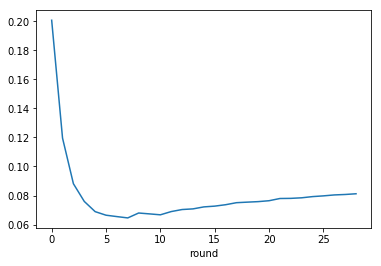

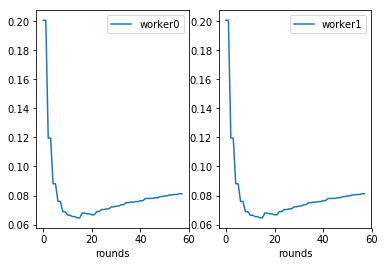

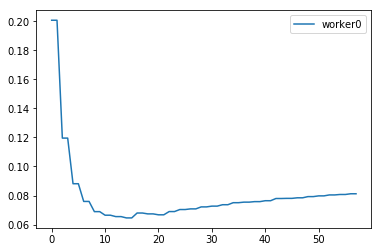

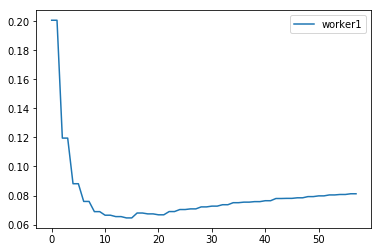

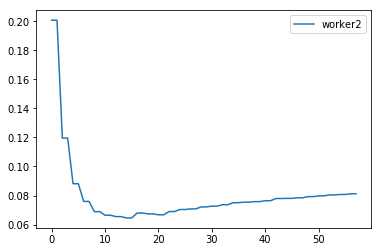

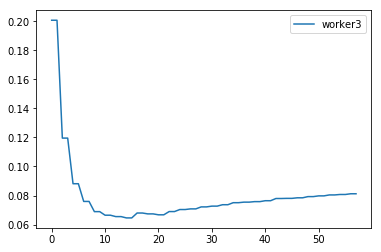

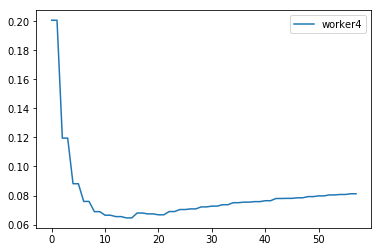

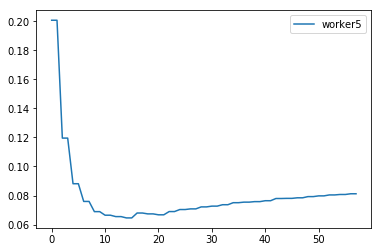

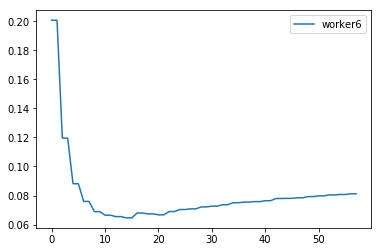

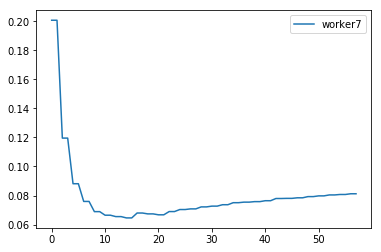

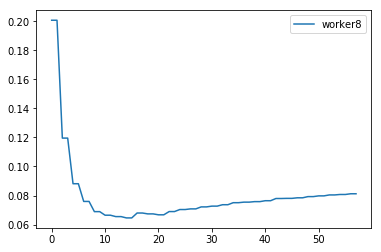

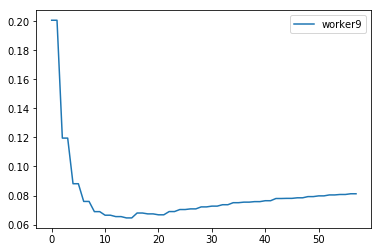

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="global loss")
ax.set_xlabel("round");


fig, ax = plt.subplots(1, 2)
ax[0].plot(manager.worker_loss_histories[0], label="worker0")
ax[0].set_xlabel("rounds")
ax[1].plot(manager.worker_loss_histories[1], label="worker1")
ax[1].set_xlabel("rounds")
ax[0].legend()
ax[1].legend();

#fig, ax = plt.subplots()

print(len(manager.worker_loss_histories))

for i in range(len(manager.worker_loss_histories)):
    
    fig, ax = plt.subplots()
    lbl = "worker" + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

#ax.legend();

#TODO Get the plots correct